In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.pipeline import Pipeline


from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/gender_submission.csv')

# EDA

In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
target = 'Survived'
variables = [i for i in train.columns if i != 'Survived']
test_size = 0.2

train_data, dev_data, train_label, dev_label = train_test_split(train[variables], train[target], test_size=test_size, random_state=666)

print('train data size: {}'.format(train_data.shape))
print('train label size: {}'.format(train_label.shape))
print('dev data size: {}'.format(dev_data.shape))
print('dev label size: {}'.format(dev_label.shape))

train data size: (712, 11)
train label size: (712,)
dev data size: (179, 11)
dev label size: (179,)


In [7]:
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
719,720,3,"Johnson, Mr. Malkolm Joackim",male,33.0,0,0,347062,7.7750,NaN,S
823,824,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.4750,E121,S
713,714,3,"Larsson, Mr. August Viktor",male,29.0,0,0,7545,9.4833,NaN,S
880,881,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
119,120,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S


### Understand the passenger distribution by variable and the survival rate

__The following variables shows clear relationship with survival and should be able to be used in the model straight out of box:__
* Pclass (class), Sex, Embarked (location embarked)

\
__I will need to understand the following variable better:__
* Name: Actual name will be useful. However, there is prefix for the name which should be explored
* Age: the data seems really sparse. Need to explore grouping data
* SibSP (# of siblings or spouse on board): seems like having 1 or 2 sibling improve the chance of survivor. It is hard to believe having more thant 2 siblines will decrease the survival rate, especially when there are not a lot of data. Will tranform the variable into has sibling or not
* Parch (# of parent or child on board): Similar to siblings variable. However, value 2 have 65 passengers and survival rate is lower compare to 1. Will group this variable into 0, 1, 2+
* Tickets: this is the ticket_number. It is interesting that some ticket number have more than 1 passengers. But I don't think think this variable will be very useful
* Fare: data is really sparse, Need to explore groupbing data
* Cabin: Maybe the letter of the cabin would be useful

In [103]:
def mean_plus_sd(x):
    if len(x) <= 1:
        return(np.nan)
    return(np.mean(x) + np.std(x)/(len(x)**0.5))

def mean_minus_sd(x):
    if len(x) <= 1:
        return(np.nan)
    return(np.mean(x) - np.std(x)/(len(x)**0.5))

def var_info(train_data, var, label=train_label, target={'Survived': [('survival_rate', 'mean'), ('sd+', mean_plus_sd), ('sd-', mean_minus_sd)]}):
    
    df = train_data.copy()
    df['Survived'] = label
    df[var].fillna('z_missing', inplace=True)  # ensure na value shows up
    
    agg_method = {**{var: [('num_pax', 'count')]}, **target}
    agg = df.groupby([var]).agg(agg_method)
    agg.columns = agg.columns.get_level_values(1)
#     if 'survival_rate_sd' in agg.columns:
#         agg.survival_rate_sd = agg.survival_rate_sd / (agg.num_pax**0.5)
    
    return(agg)
    
print('overall survival rate: {:.2%}\n'.format(train_label.mean()), '-'*100)    
for i in variables:
    display(var_info(train_data, i).sort_values(by='num_pax', ascending=False))

overall survival rate: 38.20%
 ----------------------------------------------------------------------------------------------------


,num_pax,survival_rate,sd+,sd-
PassengerId,,,,
1,1,0,NaN,NaN
614,1,0,NaN,NaN
589,1,0,NaN,NaN
590,1,0,NaN,NaN
593,1,0,NaN,NaN
...,...,...,...,...
297,1,0,NaN,NaN
300,1,1,NaN,NaN
301,1,1,NaN,NaN


,num_pax,survival_rate,sd+,sd-
Pclass,,,,
3,398,0.248744,0.270412,0.227075
1,169,0.627219,0.664415,0.590023
2,145,0.462069,0.503472,0.420666


,num_pax,survival_rate,sd+,sd-
Name,,,,
"Abelson, Mr. Samuel",1,0,NaN,NaN
"O'Driscoll, Miss. Bridget",1,1,NaN,NaN
"Newell, Miss. Madeleine",1,1,NaN,NaN
"Newell, Miss. Marjorie",1,1,NaN,NaN
"Newell, Mr. Arthur Webster",1,0,NaN,NaN
...,...,...,...,...
"Goldsmith, Mrs. Frank John (Emily Alice Brown)",1,1,NaN,NaN
"Goncalves, Mr. Manuel Estanslas",1,0,NaN,NaN
"Goodwin, Master. Harold Victor",1,0,NaN,NaN


,num_pax,survival_rate,sd+,sd-
Sex,,,,
male,461,0.188720,0.206944,0.170496
female,251,0.737052,0.764839,0.709264


,num_pax,survival_rate,sd+,sd-
Age,,,,
z_missing,138,0.289855,0.328476,0.251234
30.0,24,0.416667,0.517301,0.316032
24.0,24,0.541667,0.643374,0.439960
19.0,23,0.347826,0.447137,0.248515
22.0,21,0.428571,0.536561,0.320582
...,...,...,...,...
36.5,1,0.000000,NaN,NaN
34.5,1,0.000000,NaN,NaN
0.92,1,1.000000,NaN,NaN


,num_pax,survival_rate,sd+,sd-
SibSp,,,,
0,484,0.342975,0.364553,0.321398
1,167,0.538922,0.577496,0.500348
2,21,0.523810,0.632795,0.414824
4,16,0.125000,0.207680,0.042320
3,15,0.200000,0.303280,0.096720
8,6,0.000000,0.000000,0.000000
5,3,0.000000,0.000000,0.000000


,num_pax,survival_rate,sd+,sd-
Parch,,,,
0,542,0.341328,0.361695,0.320962
1,91,0.582418,0.634115,0.530720
2,65,0.461538,0.523372,0.399705
3,5,0.600000,0.819089,0.380911
4,4,0.000000,0.000000,0.000000
5,4,0.250000,0.466506,0.033494
6,1,0.000000,NaN,NaN


,num_pax,survival_rate,sd+,sd-
Ticket,,,,
3101295,6,0.000000,0.000000,0.000000
1601,6,0.666667,0.859117,0.474217
CA. 2343,6,0.000000,0.000000,0.000000
347088,6,0.000000,0.000000,0.000000
347082,6,0.000000,0.000000,0.000000
...,...,...,...,...
312991,1,1.000000,NaN,NaN
31028,1,0.000000,NaN,NaN
3101298,1,1.000000,NaN,NaN


,num_pax,survival_rate,sd+,sd-
Fare,,,,
8.0500,37,0.135135,0.191338,0.078932
13.0000,33,0.363636,0.447376,0.279897
7.8958,30,0.033333,0.066106,0.000560
7.7500,29,0.379310,0.469413,0.289208
26.0000,25,0.440000,0.539277,0.340723
...,...,...,...,...
12.8750,1,0.000000,NaN,NaN
12.6500,1,1.000000,NaN,NaN
12.5250,1,0.000000,NaN,NaN


,num_pax,survival_rate,sd+,sd-
Cabin,,,,
z_missing,553,0.296564,0.315987,0.277142
C23 C25 C27,4,0.500000,0.750000,0.250000
E101,3,1.000000,1.000000,1.000000
B57 B59 B63 B66,2,1.000000,1.000000,1.000000
D35,2,1.000000,1.000000,1.000000
...,...,...,...,...
C101,1,1.000000,NaN,NaN
B86,1,0.000000,NaN,NaN
B82 B84,1,0.000000,NaN,NaN


,num_pax,survival_rate,sd+,sd-
Embarked,,,,
S,510,0.331373,0.352216,0.310529
C,140,0.557143,0.599124,0.515162
Q,61,0.393443,0.455990,0.330895
z_missing,1,1.000000,NaN,NaN


### Additional analysis on the some variables

##### Explore cutoff point for age and fare

/Users/richardwang/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/richardwang/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


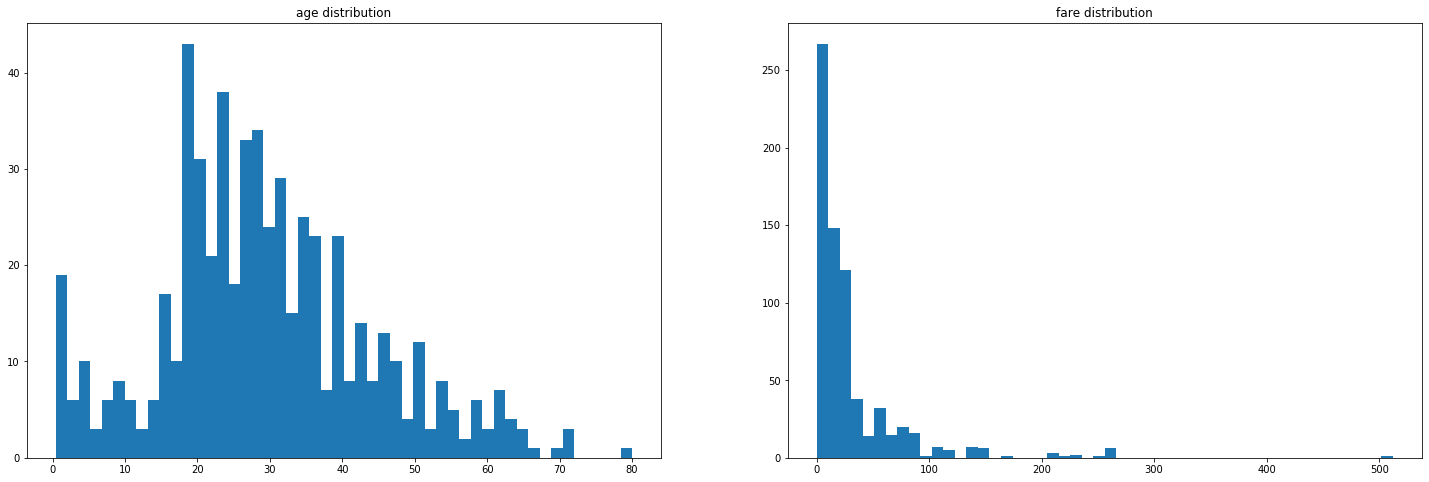

In [9]:
# age

fig, axes = plt.subplots(1, 2, figsize=(25, 8))

_ = axes[0].hist(train_data.Age, bins=50)
_ = axes[0].set_title('age distribution')

_ = axes[1].hist(train_data.Fare, bins=50)
_ = axes[1].set_title('fare distribution')

In [105]:
def round_nearest(train_data, var, nearest):
    df = train_data.copy()
#     var = var + '_' + str(nearest)
    df[var] = np.floor(train_data[var]/nearest) * nearest

    return(df)

def plt_var_info(df, ax, target={'survival_rate': {'color': 'magenta', 'style': '-', 'marker': 'o'}}, exposure='pax_count'):
    
    x_labels = [str(i).replace('.0', '') for i in df.index.tolist()]  # change x into string, remove .0
    
    # plot target
    for i in target:
        color = target[i]['color']
        style = target[i]['style']
        marker = target[i]['marker']
        ax.plot(x_labels, df[i], label=i, color=color, linestyle=style, marker=marker)
        
    
    ax_twin = ax.twinx()
    ax_twin.bar(x_labels, df.num_pax, label='pax_count', color='darkgrey')
    
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.2)
    ax_twin.set_ylim(ax_twin.get_ylim()[0], ax_twin.get_ylim()[1]*1.2)
    
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    
    
    # move ax in front
    ax.set_zorder(ax_twin.get_zorder() + 1)
    # Set ax's patch invisible
    ax.patch.set_visible(False)  # remove the patch so it is not covered by the ax's background

### Age - Test best cutoff to group the data

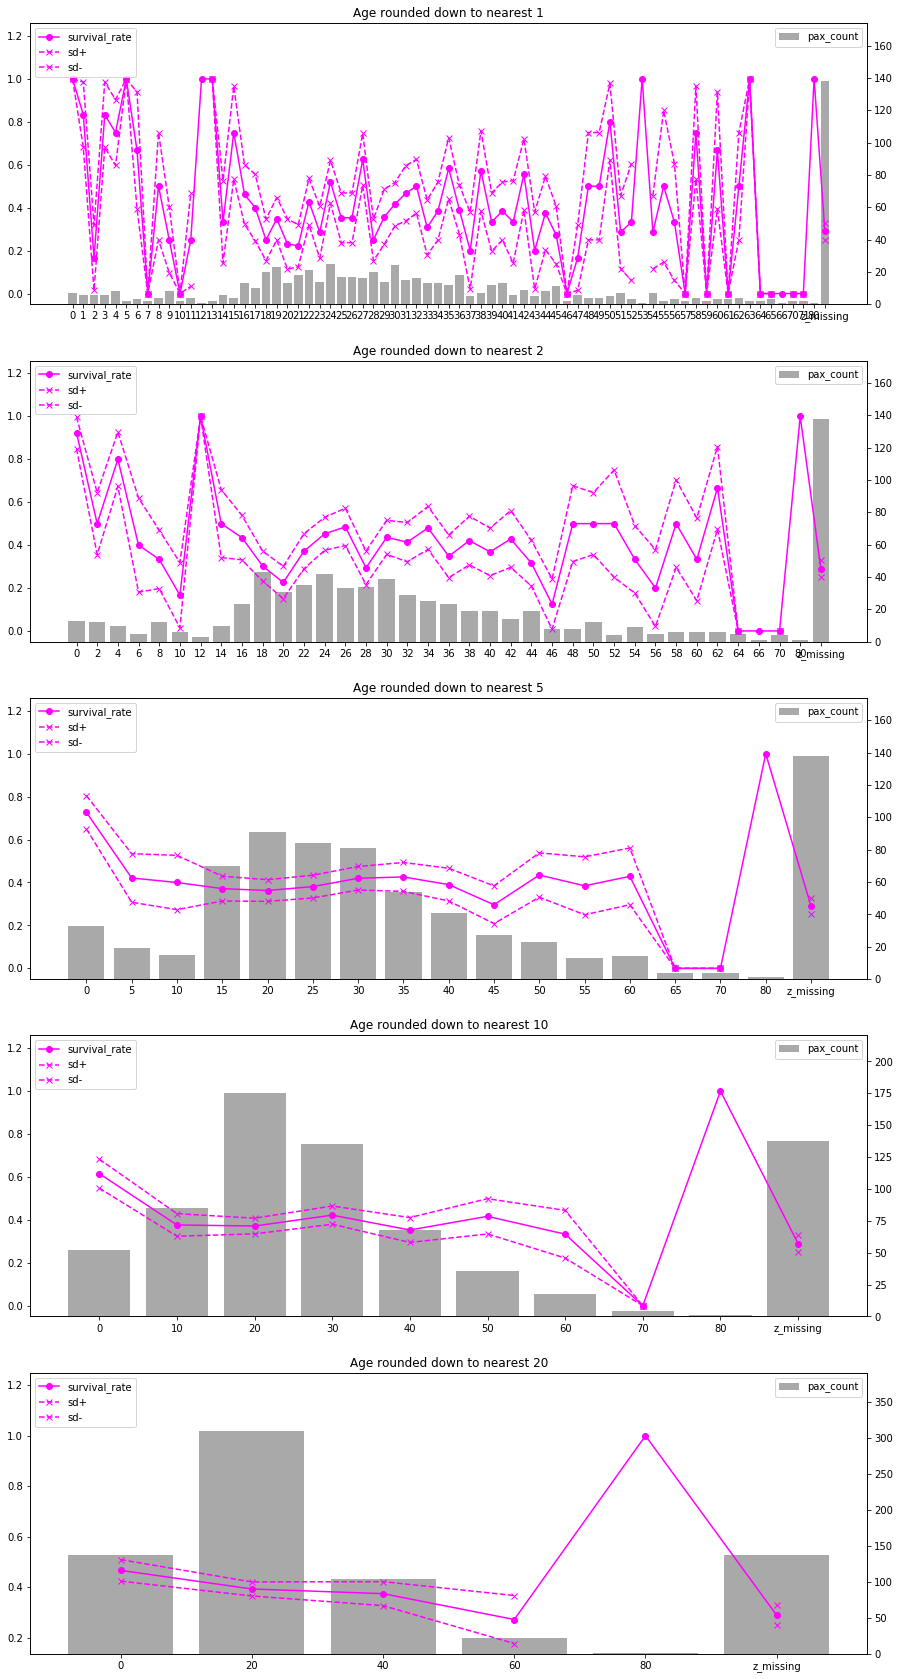

In [112]:
var = 'Age'
nearest_rounding = [1, 2, 5, 10, 20]

fig, axes = plt.subplots(len(nearest_rounding), 1, figsize=(15, 6 * len(nearest_rounding)))

for i, nearest in enumerate(nearest_rounding):
    df = var_info(round_nearest(train_data, var, nearest), var, label=train_label, target={'Survived': [('survival_rate', 'mean'), ('sd+', mean_plus_sd), ('sd-', mean_minus_sd)]})

    lines = {'survival_rate': {'color': 'magenta', 'style': '-', 'marker': 'o'}, 'sd+': {'color': 'magenta', 'style': '--', 'marker': 'x'}, 'sd-': {'color': 'magenta', 'style': '--', 'marker': 'x'}}
    plt_var_info(df, axes[i], lines, exposure='pax_count')
    axes[i].set_title('{} rounded down to nearest {}'.format(var, nearest))

### Fare - Test best cutoff to group the data

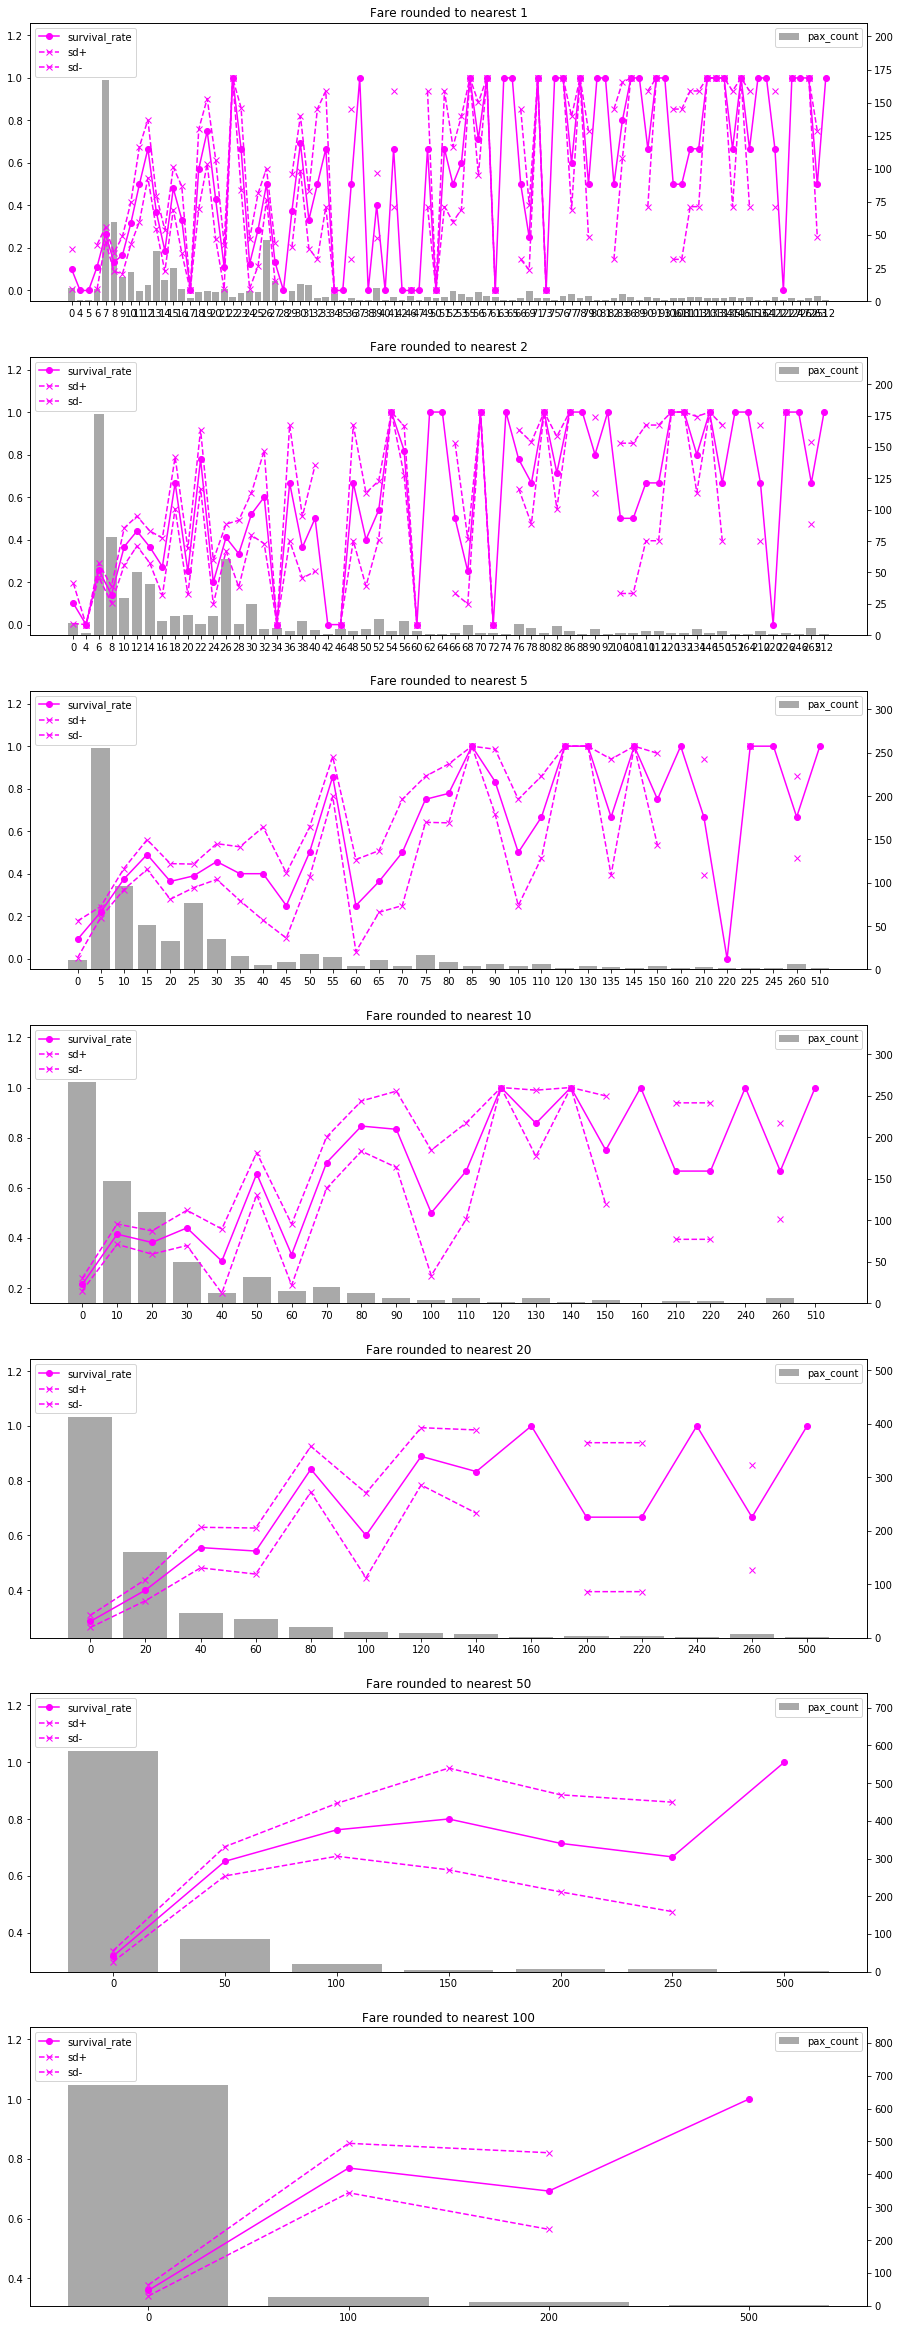

In [113]:
var = 'Fare'
nearest_rounding = [1, 2, 5, 10, 20, 50, 100]

fig, axes = plt.subplots(len(nearest_rounding), 1, figsize=(15, 6 * len(nearest_rounding)))

for i, nearest in enumerate(nearest_rounding):
    df = var_info(round_nearest(train_data, var, nearest), var, label=train_label, target={'Survived': [('survival_rate', 'mean'), ('sd+', mean_plus_sd), ('sd-', mean_minus_sd)]})

    lines = {'survival_rate': {'color': 'magenta', 'style': '-', 'marker': 'o'}, 'sd+': {'color': 'magenta', 'style': '--', 'marker': 'x'}, 'sd-': {'color': 'magenta', 'style': '--', 'marker': 'x'}}

    plt_var_info(df, axes[i], lines)
    axes[i].set_title('{} rounded to nearest {}'.format(var, nearest))

### Name

In [59]:
def prefix(train_data):
    df = train_data.copy()
    df['prefix'] = df.Name.str.split(' ').apply(lambda x: [i for i in x if '.' in i][0])  # split by space and take the one with .
    
    display(var_info(df, 'prefix'))

prefix(train_data)

,num_pax,survival_rate,survival_rate_sd
prefix,,,
Col.,1,0.000000,NaN
Countess.,1,1.000000,NaN
Don.,1,0.000000,NaN
Dr.,6,0.500000,0.223607
Major.,2,0.500000,0.500000
Master.,35,0.600000,0.084017
Miss.,143,0.692308,0.038731
Mlle.,2,1.000000,0.000000
Mme.,1,1.000000,NaN


### Cabin

In [60]:
def prefix(train_data):
    df = train_data.copy()
    df['Cabin'] = df.Cabin.str[0]
    
    display(var_info(df, 'Cabin'))

prefix(train_data)

,num_pax,survival_rate,survival_rate_sd
Cabin,,,
A,11,0.272727,0.140836
B,36,0.805556,0.066898
C,45,0.600000,0.073855
D,31,0.741935,0.079889
E,24,0.791667,0.084681
F,10,0.600000,0.163299
G,1,1.000000,NaN
T,1,0.000000,NaN
z_missing,553,0.296564,0.019440


### Data Transformation

__Age__
* Group age into `5 year increments` which captures the difference in survival rate but also is shows stable result
* Group `>= 65` into `65+` group
* Group missing value into `NA` group

__Fare__
* Group into `0-10`, `10-40`, `40-60`, `60-100`, `100+`

__Name__
* group prefix into `Master`, `Miss`, `Mr`, `Mrs`, `Other`

__Cabin__
* group prefix into `A`, `B`, `C`, `D`, `E`, `F`, `NA`

__SiSP__
* group into True of False

__Parch__
* group into `0`, `1`, `2+`

\
\
One way to do those data transformation is to tranform train and dev data one by one which can be cumbersome. Instead, I created a data transformer class to achieve scalably. We can easily include the transformer in a machine learning pipeline, so it can transform data automatically.

In [61]:
class data_transformation(BaseEstimator):
    
    '''transform the coordinates to include distances between facial features'''
    def __init__(self):
        pass
    
    def fit(self, *_):
        return self
        
    def transform(self, train_data, *_):
        X = train_data.copy()
        
        # Enbarked mod
        Embarked_category = ['C', 'Q', 'Other_Missing']
        X['Embarked_mod'] = np.where(X.Embarked.isin(Embarked_category), X.Embarked, 'S_Missing' )
        
        # age mod. NA are addressed here.
        # otherwise it will become numpy's na rather than pandas's na, will not be catch by fill na
        X['Age_mod'] = np.where(X.Age.isna(), 'Missing', 
                                np.where(X.Age >= 65, '65 +', (np.floor(X.Age/5) * 5))
                               )
        # fare mod
        X['Fare_mod'] = np.where(X.Fare >= 100, '4.[100,] ', 
                              np.where(X.Fare >= 60, '3.[60, 100)', 
                                       np.where(X.Fare >= 40, '2.[40, 60)', 
                                                np.where(X.Fare >= 10, '1.[10, 40)', '0.[0 , 10)'
                                                        )
                                               )
                                      )
                             )
        # name mod
        X['Prefix_mod'] = X.Name.str.split(' ').apply(lambda x: [i for i in x if '.' in i][0])
        Prefix_category = ['Master.', 'Miss.', 'Mr.', 'Mrs.', 'Other']
        X['Prefix_mod'] = np.where(X.Prefix_mod.isin(Prefix_category), X.Prefix_mod, 'Other' )
        # cabin mod
        X['Cabin_mod'] = X.Cabin.str[0]
        Cabin_category = ['A', 'B', 'C', 'D', 'E', 'F', 'Other_Missing']
        X['Cabin_mod'] = np.where(X.Cabin_mod.isin(Cabin_category), X.Cabin_mod, 'Other_Missing' )
        # sibsp mod
        X['SibSp_mod'] = X.SibSp > 0
        # Parch mod
        X['Parch_mod'] = np.where(X.Parch == 0, '0', 
                                  np.where(X.Parch == 1, '1', '2+')
                                 )
        
        col_to_keep = ['Pclass', 'Sex', 'Embarked_mod', 'Age_mod', 'Fare_mod', 'Prefix_mod', 'Cabin_mod', 'SibSp_mod', 'Parch_mod']
        
        return(X[col_to_keep].fillna('missing'))

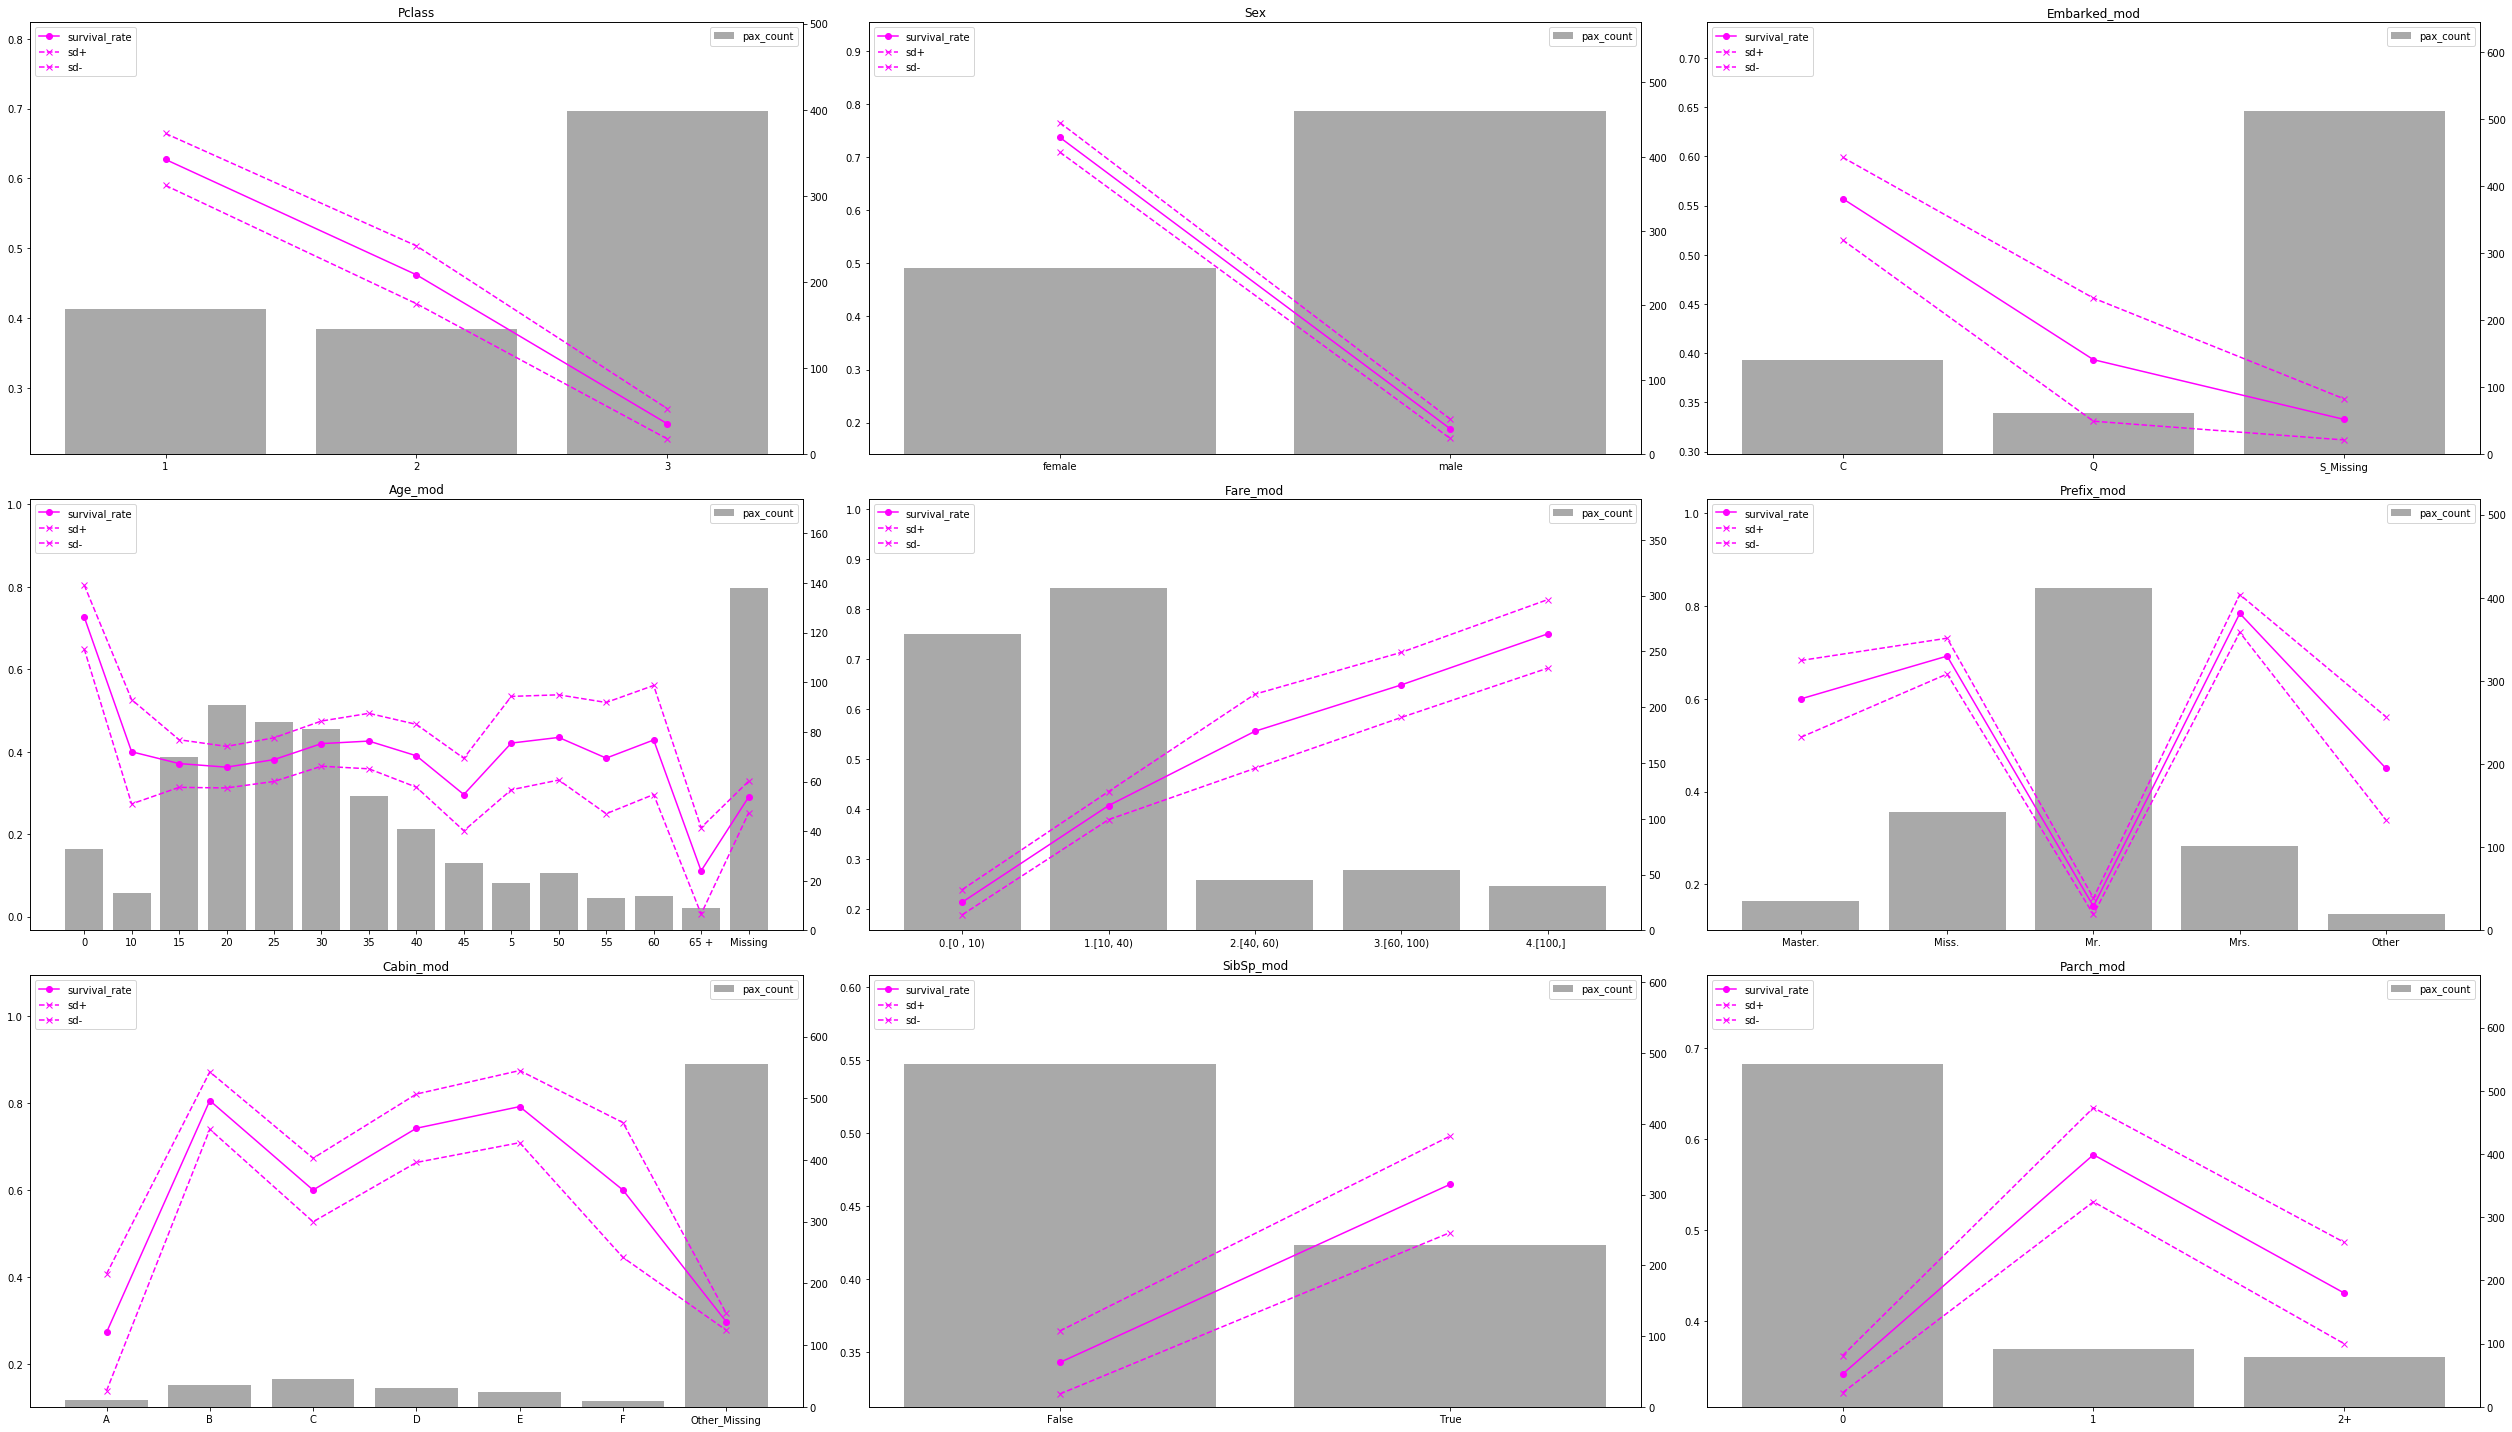

In [115]:
transformed_data = data_transformation().transform(train_data)

fig, axes = plt.subplots(3, 3, figsize=(35, 20))
axes = axes.flatten()

for col, ax in zip(transformed_data.columns, axes):
    df = var_info(transformed_data, col, label=train_label, target={'Survived': [('survival_rate', 'mean'), ('sd+', mean_plus_sd), ('sd-', mean_minus_sd)]})

    lines = {'survival_rate': {'color': 'magenta', 'style': '-', 'marker': 'o'}, 'sd+': {'color': 'magenta', 'style': '--', 'marker': 'x'}, 'sd-': {'color': 'magenta', 'style': '--', 'marker': 'x'}}


    plt_var_info(df, ax, lines, exposure='num_pax')
    ax.set_title(col)
fig.tight_layout()

### Correlation matrix

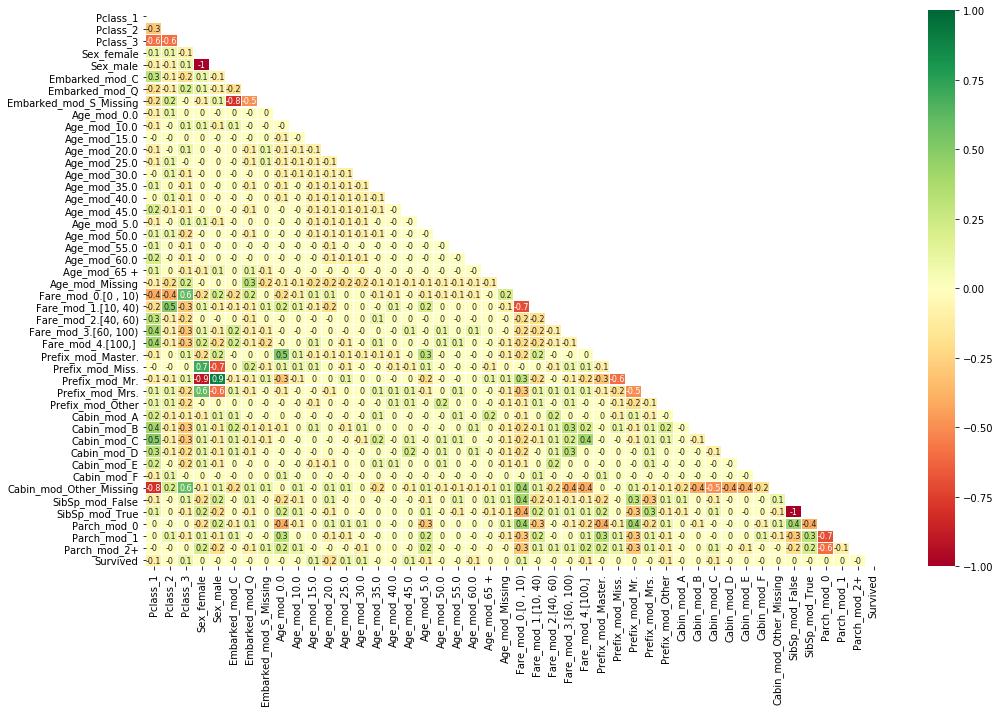

In [67]:
OHE = OneHotEncoder(sparse=False)
df = pd.DataFrame(OHE.fit_transform(transformed_data))
df.columns = OHE.get_feature_names(transformed_data.columns)
df['Survived'] = train_label

fig, ax = plt.subplots(figsize=(15, 10))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr().round(1), mask=mask, annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'fontsize': 8})

# ax.set_xticklabels(ax.get_xticklabels(), rotation=-60, horizontalalignment='left')
fig.tight_layout()

### Train Mode

__Logistic Regression__
* Set up Machine Learning Pipeline
* Use Gridsearch to tune hyperparameters `C`

best result
> C: 0.160

In [68]:
# setup  pipe_line
pipe = Pipeline([('data_train', data_transformation()), 
                 ('one_hot', OneHotEncoder()), 
                 ('clf', LogisticRegression())])

# iteration of parameters
params = {'clf__C': [0.001, 0.01, 0.05, 0.1, 1, 5, 10, 50, 100, 1000]}
params = {'clf__C': [0.01, 0.05, 0.075, 0.1, 0.2, 0.3, 0.5, 1]}
params = {'clf__C': [0.075, 0.09, 0.1, 0.15, 0.2, 0.3]}
params = {'clf__C': [round(i * 0.01 + 0.1, 3) for i in range(10)]}

# set up gridsearch and fit model
log_grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
log_grid.fit(train_data, train_label)

result = log_grid.cv_results_  # gridsearch result

# print the best result
string = 'C: {:<5.3f} | accuracy: {:.10f}'
print('best result', ('\n' + string).format(log_grid.best_params_['clf__C'], log_grid.best_score_))
print('-'*100)

# print result by parameter
for param, acc, sd in zip(result['params'], result['mean_test_score'], result['std_test_score']):
    print((string + ' | accuracy SD:{:.5f}').format(param['clf__C'], acc, sd))

best result 
C: 0.160 | accuracy: 0.8174295775
----------------------------------------------------------------------------------------------------
C: 0.100 | accuracy: 0.8118348983 | accuracy SD:0.04020
C: 0.110 | accuracy: 0.8118348983 | accuracy SD:0.04020
C: 0.120 | accuracy: 0.8160406886 | accuracy SD:0.03939
C: 0.130 | accuracy: 0.8160406886 | accuracy SD:0.03888
C: 0.140 | accuracy: 0.8160406886 | accuracy SD:0.03888
C: 0.150 | accuracy: 0.8146322379 | accuracy SD:0.03699
C: 0.160 | accuracy: 0.8174295775 | accuracy SD:0.03661
C: 0.170 | accuracy: 0.8146322379 | accuracy SD:0.03904
C: 0.180 | accuracy: 0.8146322379 | accuracy SD:0.03904
C: 0.190 | accuracy: 0.8146322379 | accuracy SD:0.03904


__GBM__
* Set up Machine Learning Pipeline
* Use Gridsearch to tune hyperparameters `learning_rate`, `max_depth`, `min_child_weight`

best result in both accuracy and standard deviation of accuracy:
>Learning Rate: 0.1500 | max_depth: 3 | min_child_weight: 10

In [69]:
# setup  pipe_line
pipe = Pipeline([('data_train', data_transformation()), 
                 ('one_hot', OneHotEncoder()), 
                 ('clf', XGBClassifier(set_seed=0))])

# iteration of parameters
params = {'clf__learning_rate': [0.01, 0.1, 1],
          'clf__max_depth': [1, 3, 5, 7], 
          'clf__min_child_weight': [1, 2, 3, 5, 10]}

params = {'clf__learning_rate': [0.005, 0.01, 0.015, 0.05, 0.1, 0.15],
          'clf__max_depth': [2, 3, 4], 
          'clf__min_child_weight': [5, 10, 15]}

params = {'clf__learning_rate': [0.13, 0.15, 0.17],
          'clf__max_depth': [3, 4], 
          'clf__min_child_weight': [5, 10, 15]}

params = {'clf__learning_rate': [0.14, 0.15, 0.16],
          'clf__max_depth': [3, 4], 
          'clf__min_child_weight': [5, 10, 15]}

# set up gridsearch and fit model
XGB_grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
XGB_grid.fit(train_data, train_label)

result = XGB_grid.cv_results_  # gridsearch result

# print the best result
string = 'Learning Rate: {:<5.4f} | max_depth: {} | min_child_weight: {} | accuracy: {:.10f}'
print('best result:',('\n' + string).format(XGB_grid.best_params_['clf__learning_rate'], 
                                            XGB_grid.best_params_['clf__max_depth'], 
                                            XGB_grid.best_params_['clf__min_child_weight'],
                                            XGB_grid.best_score_))
print('-'*100)

# print avg result by each of the parameters
def print_avg_score(var): 
    param_values = [param['clf__' + var] for param in result['params']]
    for i in sorted(set(param_values)):
        scores = result['mean_test_score'][[p == i for p in param_values]]  # scores for corresponding parameter
        mean_score = np.mean(scores)
        
        scores_sd = result['std_test_score'][[p == i for p in param_values]]  # scores for corresponding parameter
        mean_score_sd = np.mean(scores_sd)
        print('{} {:<5.4f} | avg accuracy: {:.10f} | accuracy SD:{:.10f}'.format(var, i, mean_score, mean_score_sd))
    print('-'*100)
        
print_avg_score('learning_rate')     
print_avg_score('max_depth')     
print_avg_score('min_child_weight')     


# print result by each of the parameters
for param, acc, sd in zip(result['params'], result['mean_test_score'], result['std_test_score']):
    print((string + ' | accuracy SD:{}').format(param['clf__learning_rate'],
                                               param['clf__max_depth'],
                                               param['clf__min_child_weight'],
                                               acc, 
                                               sd))

best result: 
Learning Rate: 0.1500 | max_depth: 3 | min_child_weight: 10 | accuracy: 0.8286384977
----------------------------------------------------------------------------------------------------
learning_rate 0.1400 | avg accuracy: 0.8162102243 | accuracy SD:0.0314701445
learning_rate 0.1500 | avg accuracy: 0.8169242306 | accuracy SD:0.0322688671
learning_rate 0.1600 | avg accuracy: 0.8180881586 | accuracy SD:0.0337129448
----------------------------------------------------------------------------------------------------
max_depth 3.0000 | avg accuracy: 0.8156668405 | accuracy SD:0.0322472701
max_depth 4.0000 | avg accuracy: 0.8184815684 | accuracy SD:0.0327207008
----------------------------------------------------------------------------------------------------
min_child_weight 5.0000 | avg accuracy: 0.8148571987 | accuracy SD:0.0386934659
min_child_weight 10.0000 | avg accuracy: 0.8260465571 | accuracy SD:0.0251213181
min_child_weight 15.0000 | avg accuracy: 0.8103188576 | accu

__RF__
* Set up Machine Learning Pipeline
* Use Gridsearch to tune hyperparameters  `max_depth`, `min_child_weight`

best result in both accuracy:
max_depth: 5 | min_samples_leaf: 1

In [70]:
# setup  pipe_line
pipe = Pipeline([('data_train', data_transformation()), 
                 ('one_hot', OneHotEncoder()), 
                 ('clf', RandomForestClassifier(random_state=0))])

# iteration of parameters
params = {'clf__max_depth': [1, 3, 5, 7], 
          'clf__min_samples_leaf': [1, 2, 3, 5, 10]}

params = {'clf__max_depth': [3, 4, 5, 6, 7], 
          'clf__min_samples_leaf': [1, 2, 3]}

# set up gridsearch and fit model
RF_grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
RF_grid.fit(train_data, train_label)

result = RF_grid.cv_results_  # gridsearch result

# print the best result
string = 'max_depth: {} | min_samples_leaf: {} | accuracy: {:.10f}'
print('best result:',('\n' + string).format(RF_grid.best_params_['clf__max_depth'], 
                                            RF_grid.best_params_['clf__min_samples_leaf'],
                                            RF_grid.best_score_))
print('-'*100)

# print avg result by each of the parameters
def print_avg_score(var): 
    param_values = [param['clf__' + var] for param in result['params']]
    for i in sorted(set(param_values)):
        scores = result['mean_test_score'][[p == i for p in param_values]]  # scores for corresponding parameter
        mean_score = np.mean(scores)
        
        scores_sd = result['std_test_score'][[p == i for p in param_values]]  # scores for corresponding parameter
        mean_score_sd = np.mean(scores_sd)
        print('{} {:<5.4f} | avg accuracy: {:.10f} | accuracy SD:{:.10f}'.format(var, i, mean_score, mean_score_sd))
    print('-'*100)
             
print_avg_score('max_depth')     
print_avg_score('min_samples_leaf')     


# print result by each of the parameters
for param, acc, sd in zip(result['params'], result['mean_test_score'], result['std_test_score']):
    print((string + ' | accuracy SD:{}').format(param['clf__max_depth'],
                                                param['clf__min_samples_leaf'],
                                                acc, 
                                                sd))

best result: 
max_depth: 5 | min_samples_leaf: 1 | accuracy: 0.8159820031
----------------------------------------------------------------------------------------------------
max_depth 3.0000 | avg accuracy: 0.7982263954 | accuracy SD:0.0340902908
max_depth 4.0000 | avg accuracy: 0.8127543036 | accuracy SD:0.0279601700
max_depth 5.0000 | avg accuracy: 0.8141105895 | accuracy SD:0.0348232029
max_depth 6.0000 | avg accuracy: 0.8085028691 | accuracy SD:0.0340690154
max_depth 7.0000 | avg accuracy: 0.8127217006 | accuracy SD:0.0320624987
----------------------------------------------------------------------------------------------------
min_samples_leaf 1.0000 | avg accuracy: 0.8106611894 | accuracy SD:0.0328681079
min_samples_leaf 2.0000 | avg accuracy: 0.8075743349 | accuracy SD:0.0327937843
min_samples_leaf 3.0000 | avg accuracy: 0.8095539906 | accuracy SD:0.0321412144
----------------------------------------------------------------------------------------------------
max_depth: 3 | min

__SVC__
* Set up Machine Learning Pipeline
* Use Gridsearch to tune hyperparameters  `C`,

best result in both accuracy:
>C: 0.575

In [128]:
# setup  pipe_line
pipe = Pipeline([('data_train', data_transformation()), 
                 ('one_hot', OneHotEncoder()), 
                 ('clf', SVC(random_state=0))])


# iteration of parameters
params = {'clf__C': [0.001, 0.01, 0.05, 0.1, 1, 5, 10, 50, 100, 1000]}
params = {'clf__C': [0.5, 1, 1.5]}
params = {'clf__C': [0.3, 0.5, 0.7]}
params = {'clf__C': [0.4, 0.5, 0.6]}
params = {'clf__C': [0.55, 0.6, 0.65]}
params = {'clf__C': [0.575, 0.6, 0.625]}

# set up gridsearch and fit model
SVC_grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
SVC_grid.fit(train_data, train_label)

result = SVC_grid.cv_results_  # gridsearch result

# print the best result
string = 'C: {:<5.3f} | accuracy: {:.15f}'
print('best result', ('\n' + string).format(SVC_grid.best_params_['clf__C'], SVC_grid.best_score_))
print('-'*100)

# print result by parameter
for param, acc, sd in zip(result['params'], result['mean_test_score'], result['std_test_score']):
    print((string + ' | accuracy SD:{:.5f}').format(param['clf__C'], acc, sd))

best result 
C: 0.575 | accuracy: 0.817449139280125
----------------------------------------------------------------------------------------------------
C: 0.575 | accuracy: 0.817449139280125 | accuracy SD:0.03852
C: 0.600 | accuracy: 0.817449139280125 | accuracy SD:0.03852
C: 0.625 | accuracy: 0.816040688575900 | accuracy SD:0.03877


### Result on dev data

In [129]:
log = log_grid.best_estimator_
XGB = XGB_grid.best_estimator_
RF = RF_grid.best_estimator_
SVC = SVC_grid.best_estimator_


print('logistic regression dev accuracy: {:.3%} | Kaggle Score: {:.3%}'.format(accuracy_score(dev_label, log.predict(dev_data)), 0.76076))
print('XGBoost dev accuracy: {:.3%} | Kaggle Score: {:.3%}'.format(accuracy_score(dev_label, XGB.predict(dev_data)), 0.78468))
print('Random Forest dev accuracy: {:.3%} | Kaggle Score: {:.3%}'.format(accuracy_score(dev_label, RF.predict(dev_data)), 0.78947))
print('Support Vector Machine dev accuracy: {:.3%} | Kaggle Score: {:.3%}'.format(accuracy_score(dev_label, SVC.predict(dev_data)), 0.78947))

logistic regression dev accuracy: 81.564% | Kaggle Score: 76.076%
XGBoost dev accuracy: 78.771% | Kaggle Score: 78.468%
Random Forest dev accuracy: 81.564% | Kaggle Score: 78.947%
Support Vector Machine dev accuracy: 81.006% | Kaggle Score: 78.947%


### Error Analysis

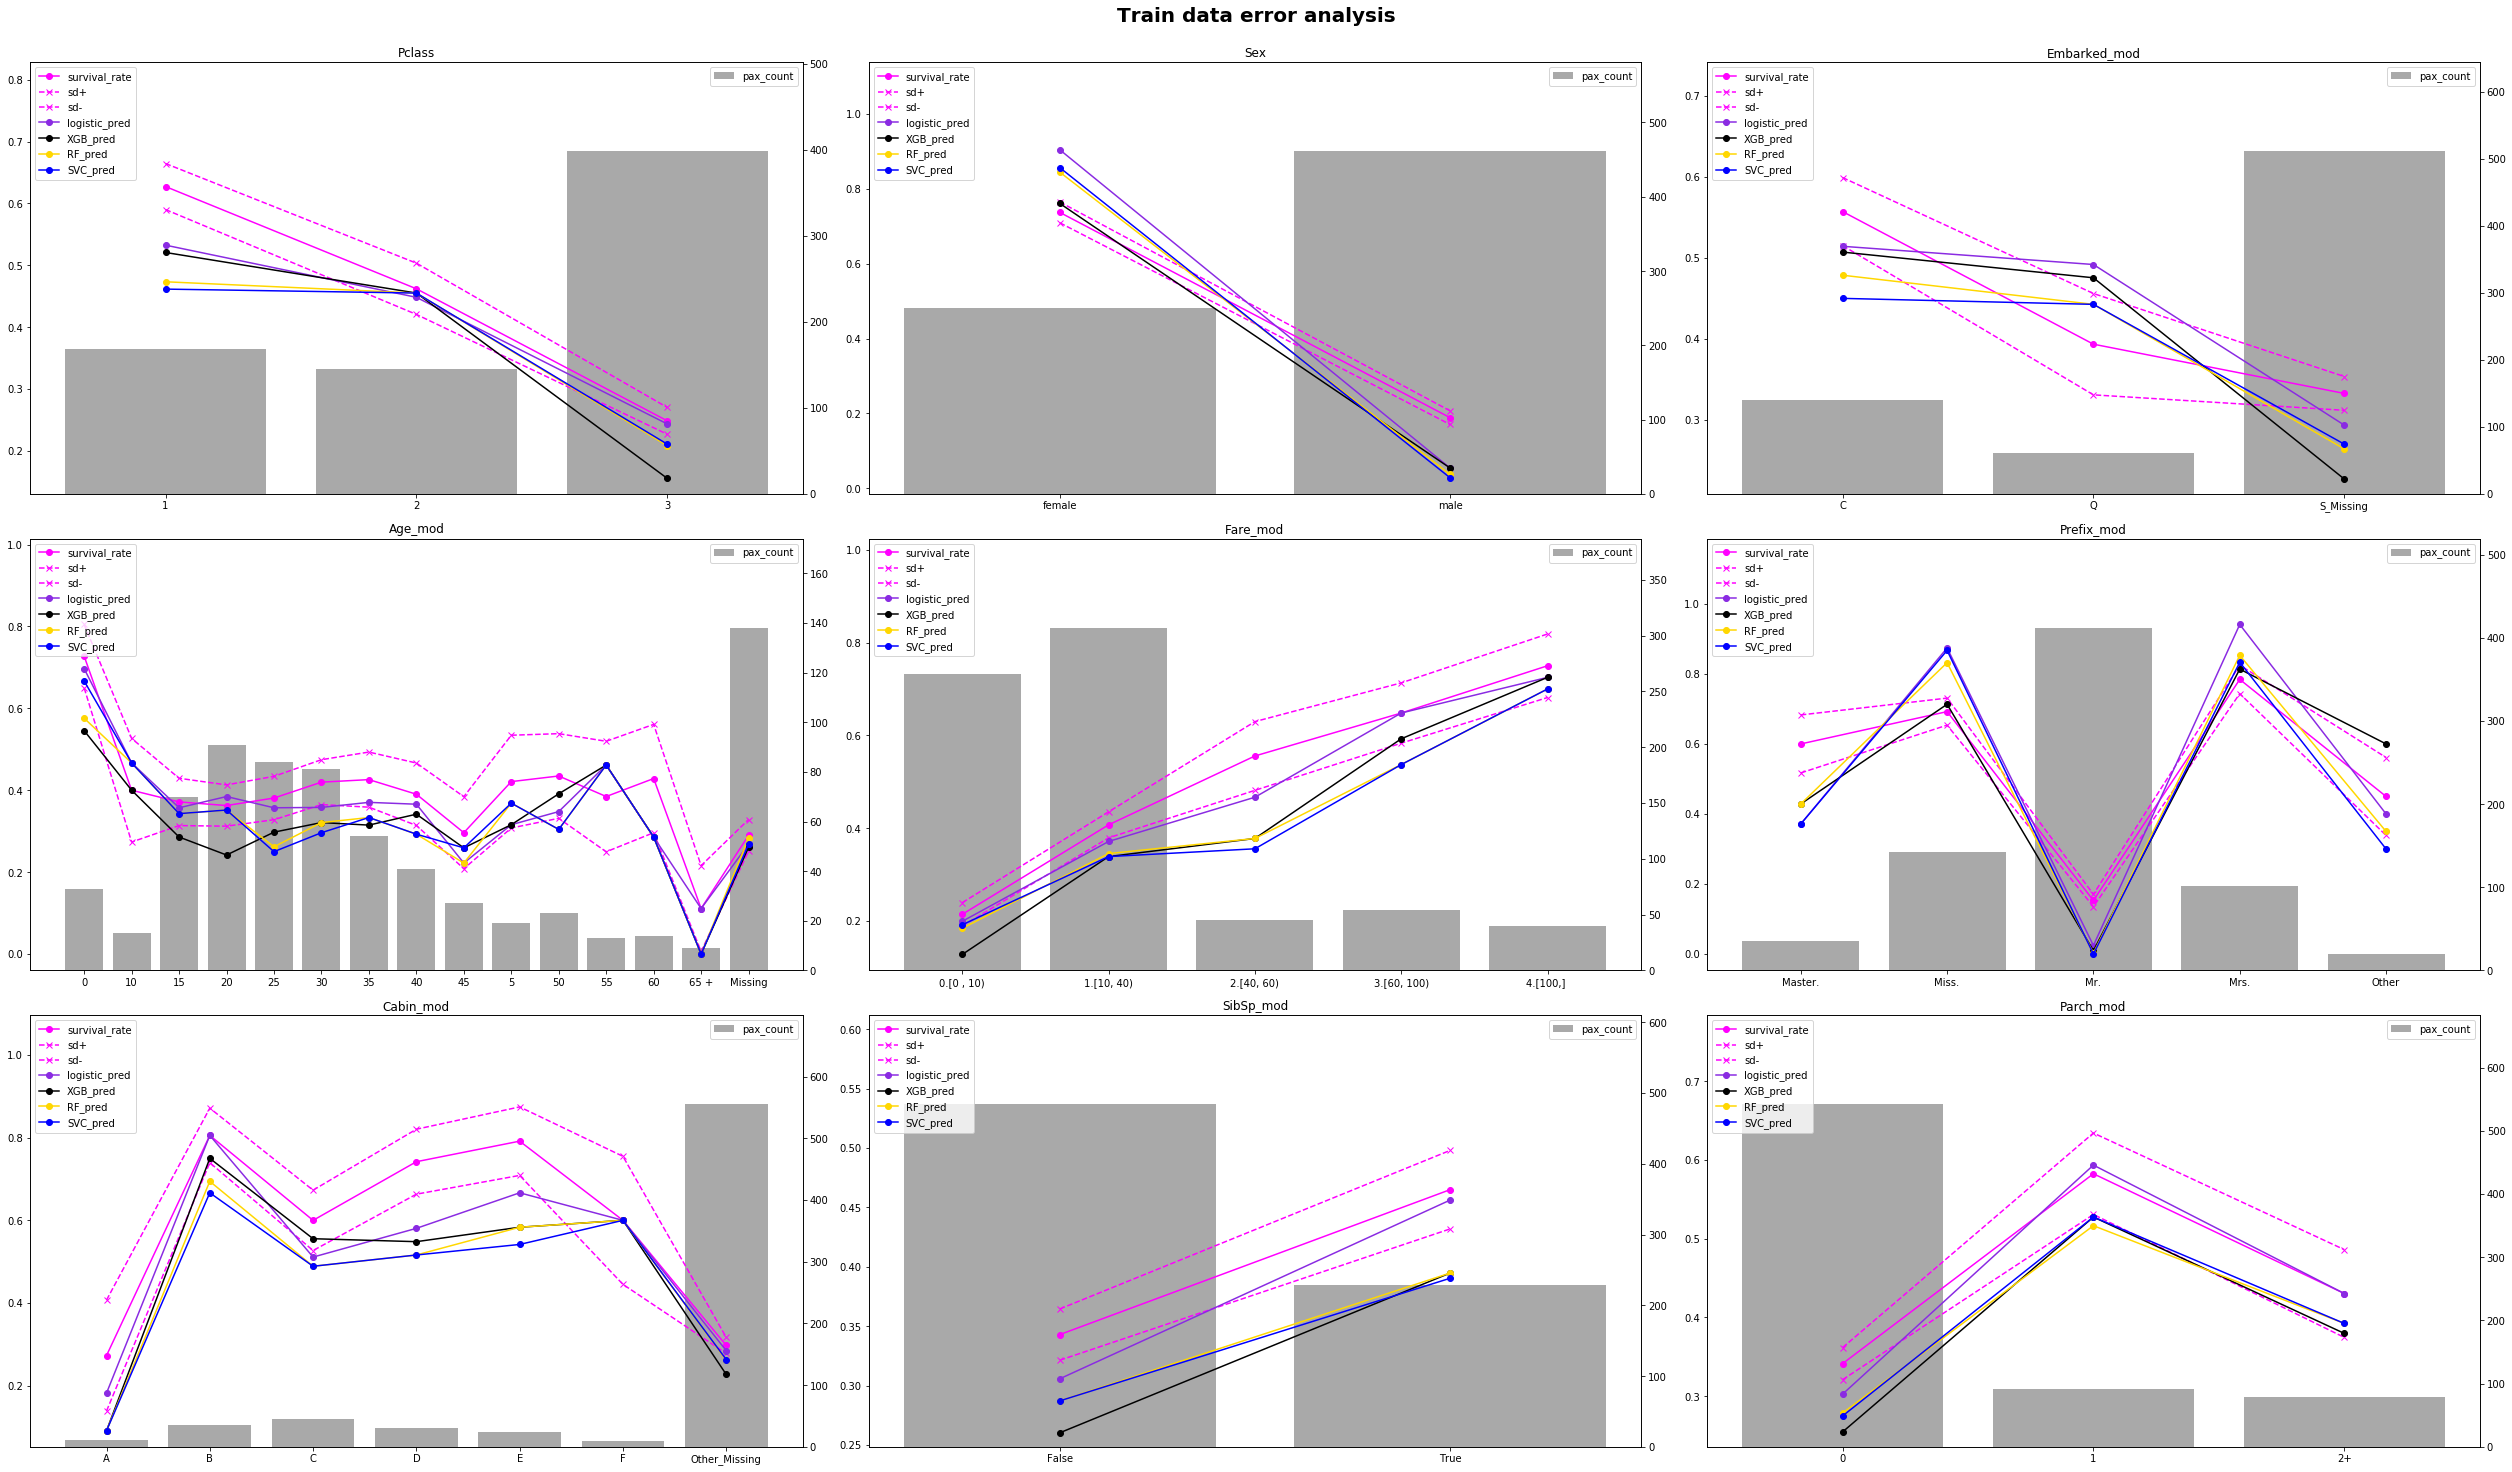

In [130]:
transformed_data = data_transformation().transform(train_data)
transformed_data['logistc_pred'] = log.predict(train_data)
transformed_data['XGB_pred'] = XGB.predict(train_data)
transformed_data['RF_pred'] = RF.predict(train_data)
transformed_data['SVC_pred'] = SVC.predict(train_data)


fig, axes = plt.subplots(3, 3, figsize=(35, 20))
axes = axes.flatten()

for col, ax in zip(transformed_data.columns, axes):
    df = var_info(transformed_data, col, label=train_label, target={'Survived': [('survival_rate', 'mean'), ('sd+', mean_plus_sd), ('sd-', mean_minus_sd)], 
                                                                    'logistc_pred': [('logistic_pred', 'mean')], 'XGB_pred': [('XGB_pred', 'mean')], 'RF_pred': [('RF_pred', 'mean')],
                                                                    'SVC_pred': [('SVC_pred', 'mean')]})

    lines = {'survival_rate': {'color': 'magenta', 'style': '-', 'marker': 'o'}, 'sd+': {'color': 'magenta', 'style': '--', 'marker': 'x'}, 'sd-': {'color': 'magenta', 'style': '--', 'marker': 'x'},
             'logistic_pred': {'color': 'blueviolet', 'style': '-', 'marker': 'o'}, 'XGB_pred': {'color': 'black', 'style': '-', 'marker': 'o'}, 'RF_pred': {'color': 'gold', 'style': '-', 'marker': 'o'}, 
             'SVC_pred': {'color': 'blue', 'style': '-', 'marker': 'o'}}


    plt_var_info(df, ax, lines, exposure='num_pax')
    ax.set_title(col)
    
fig.suptitle('Train data error analysis', fontsize=20, fontweight='bold', y=1.02)
fig.tight_layout()

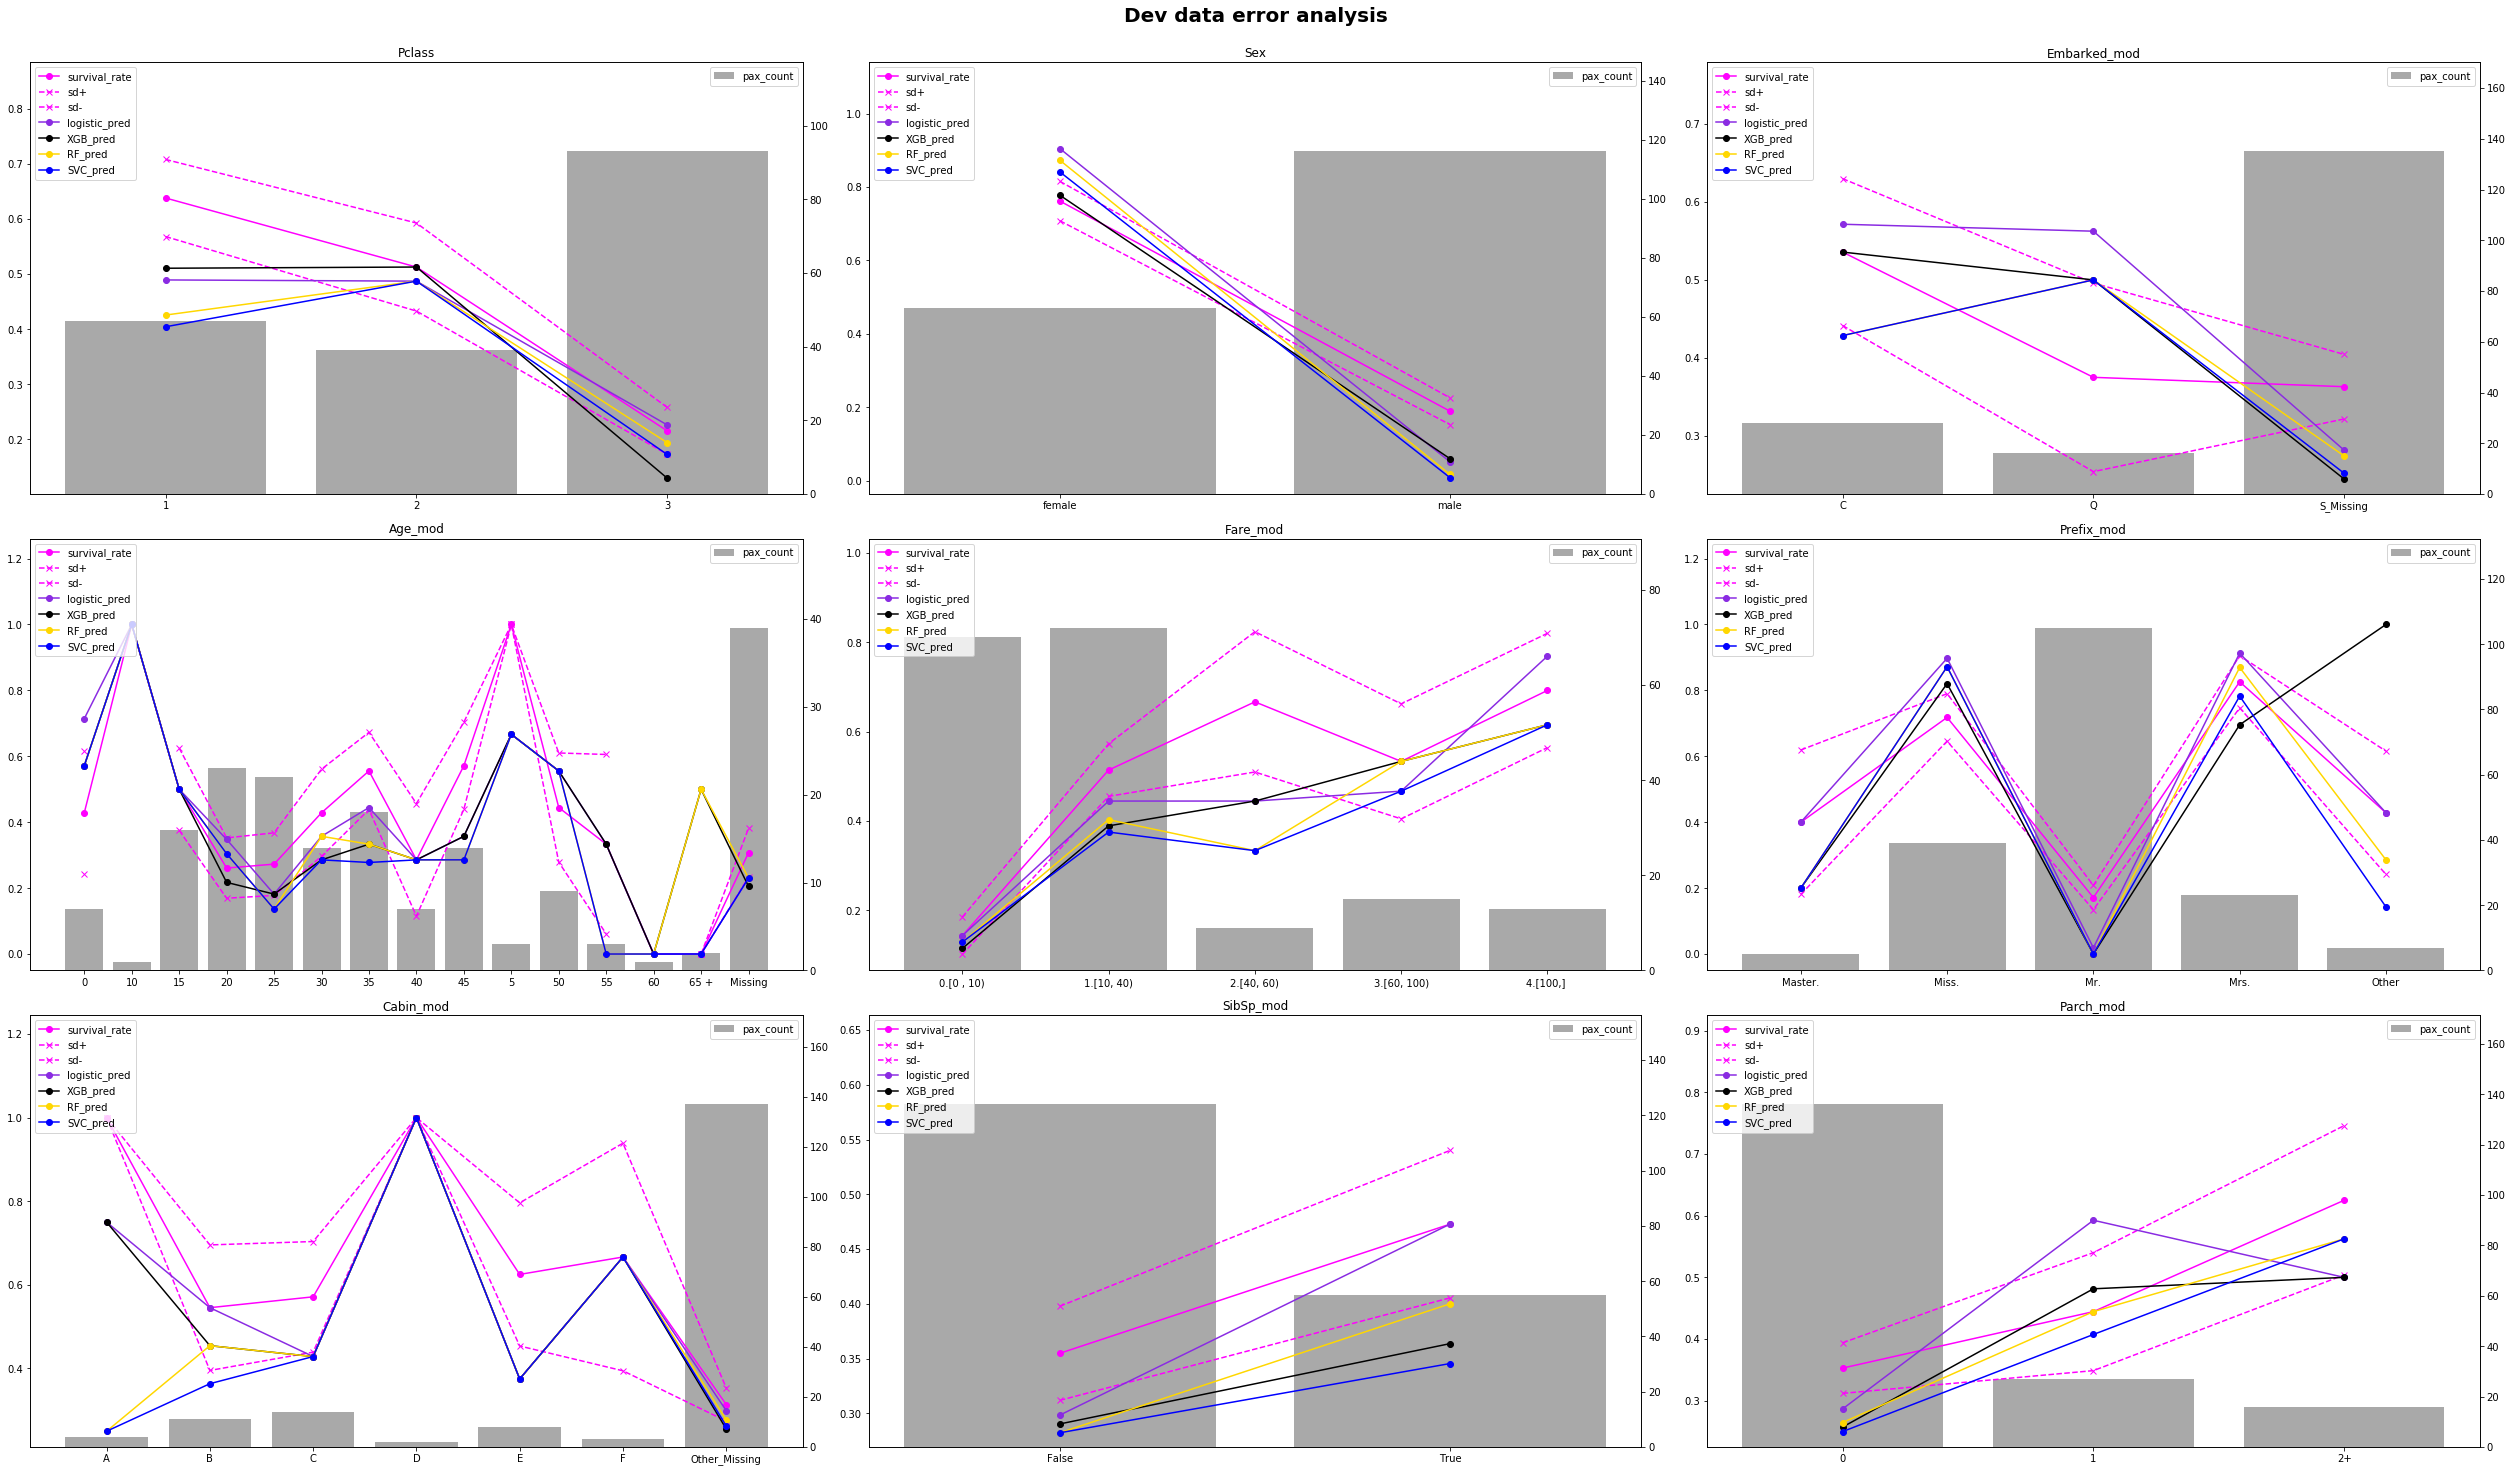

In [131]:
transformed_data = data_transformation().transform(dev_data)
transformed_data['logistc_pred'] = log.predict(dev_data)
transformed_data['XGB_pred'] = XGB.predict(dev_data)
transformed_data['RF_pred'] = RF.predict(dev_data)
transformed_data['SVC_pred'] = SVC.predict(dev_data)


fig, axes = plt.subplots(3, 3, figsize=(35, 20))
axes = axes.flatten()

for col, ax in zip(transformed_data.columns, axes):
    df = var_info(transformed_data, col, label=dev_label, target={'Survived': [('survival_rate', 'mean'), ('sd+', mean_plus_sd), ('sd-', mean_minus_sd)], 
                                                                    'logistc_pred': [('logistic_pred', 'mean')], 'XGB_pred': [('XGB_pred', 'mean')], 'RF_pred': [('RF_pred', 'mean')],
                                                                    'SVC_pred': [('SVC_pred', 'mean')]})

    lines = {'survival_rate': {'color': 'magenta', 'style': '-', 'marker': 'o'}, 'sd+': {'color': 'magenta', 'style': '--', 'marker': 'x'}, 'sd-': {'color': 'magenta', 'style': '--', 'marker': 'x'},
             'logistic_pred': {'color': 'blueviolet', 'style': '-', 'marker': 'o'}, 'XGB_pred': {'color': 'black', 'style': '-', 'marker': 'o'}, 'RF_pred': {'color': 'gold', 'style': '-', 'marker': 'o'}, 
             'SVC_pred': {'color': 'blue', 'style': '-', 'marker': 'o'}}
    
    plt_var_info(df, ax, lines, exposure='num_pax')
    ax.set_title(col)
    
fig.suptitle('Dev data error analysis', fontsize=20, fontweight='bold', y=1.02)
fig.tight_layout()

### Error analysis on Biase vs. Variance

__Bias__
Based on the error analysis, all the models seems to have high bias. The high bias even occurres when aggregating prediction over variables like gender. If the high bias only happens to logistic regress, the problem could be the linear decision boundary is too simple for this problem. However, the bias problem occurres for flexiable models like GBM, random forest, and SVM, so I believe there is a lot of inherent noise in the dataset which leads to high bias.

__Variance__
The Kaggle scores much lower compare to the Gridsearch score or dev dataset. I believe there are some over fitting because some of the relationship in train dataset does not hold in dev dataset. Will need to regroup variables into larger bucket.
* Age_mod: group in to `10 year increments`
* Cabin_mod: group into `A-F`, `other_missing`
* Parch_mod: group into `True or False`

### Update Model

In [24]:
class data_transformation_v1(BaseEstimator):
    
    '''transform the coordinates to include distances between facial features'''
    def __init__(self):
        pass
    
    def fit(self, *_):
        return self
        
    def transform(self, train_data, *_):
        X = train_data.copy()
        
        # Enbarked mod
        Embarked_category = ['C', 'Q', 'Other_Missing']
        X['Embarked_mod'] = np.where(X.Embarked.isin(Embarked_category), X.Embarked, 'S_Missing' )
        
        # age mod. NA are addressed here.
        # otherwise it will become numpy's na rather than pandas's na, will not be catch by fill na
        X['Age_mod'] = np.where(X.Age.isna(), 'Missing', 
                                np.where(X.Age >= 60, '60 +', (np.floor(X.Age/10) * 10))
                               )
        # fare mod
        X['Fare_mod'] = np.where(X.Fare >= 100, '4.[100,] ', 
                              np.where(X.Fare >= 60, '3.[60, 100)', 
                                       np.where(X.Fare >= 40, '2.[40, 60)', 
                                                np.where(X.Fare >= 10, '1.[10, 40)', '0.[0 , 10)'
                                                        )
                                               )
                                      )
                             )
        # name mod
        X['Prefix_mod'] = X.Name.str.split(' ').apply(lambda x: [i for i in x if '.' in i][0])
        Prefix_category = ['Master.', 'Miss.', 'Mr.', 'Mrs.', 'Other']
        X['Prefix_mod'] = np.where(X.Prefix_mod.isin(Prefix_category), X.Prefix_mod, 'Other' )
        # cabin mod
        X['Cabin_mod'] = X.Cabin.str[0]
        Cabin_category = ['A', 'B', 'C', 'D', 'E', 'F', 'Other_Missing']
        X['Cabin_mod'] = np.where(X.Cabin_mod.isin(Cabin_category), 'A to F', 'Other_Missing' )
        # sibsp mod
        X['SibSp_mod'] = X.SibSp > 0
        # Parch mod
        X['Parch_mod'] = X.Parch > 0
        
        col_to_keep = ['Pclass', 'Sex', 'Embarked_mod', 'Age_mod', 'Fare_mod', 'Prefix_mod', 'Cabin_mod', 'SibSp_mod', 'Parch_mod']
        
        return(X[col_to_keep].fillna('missing'))

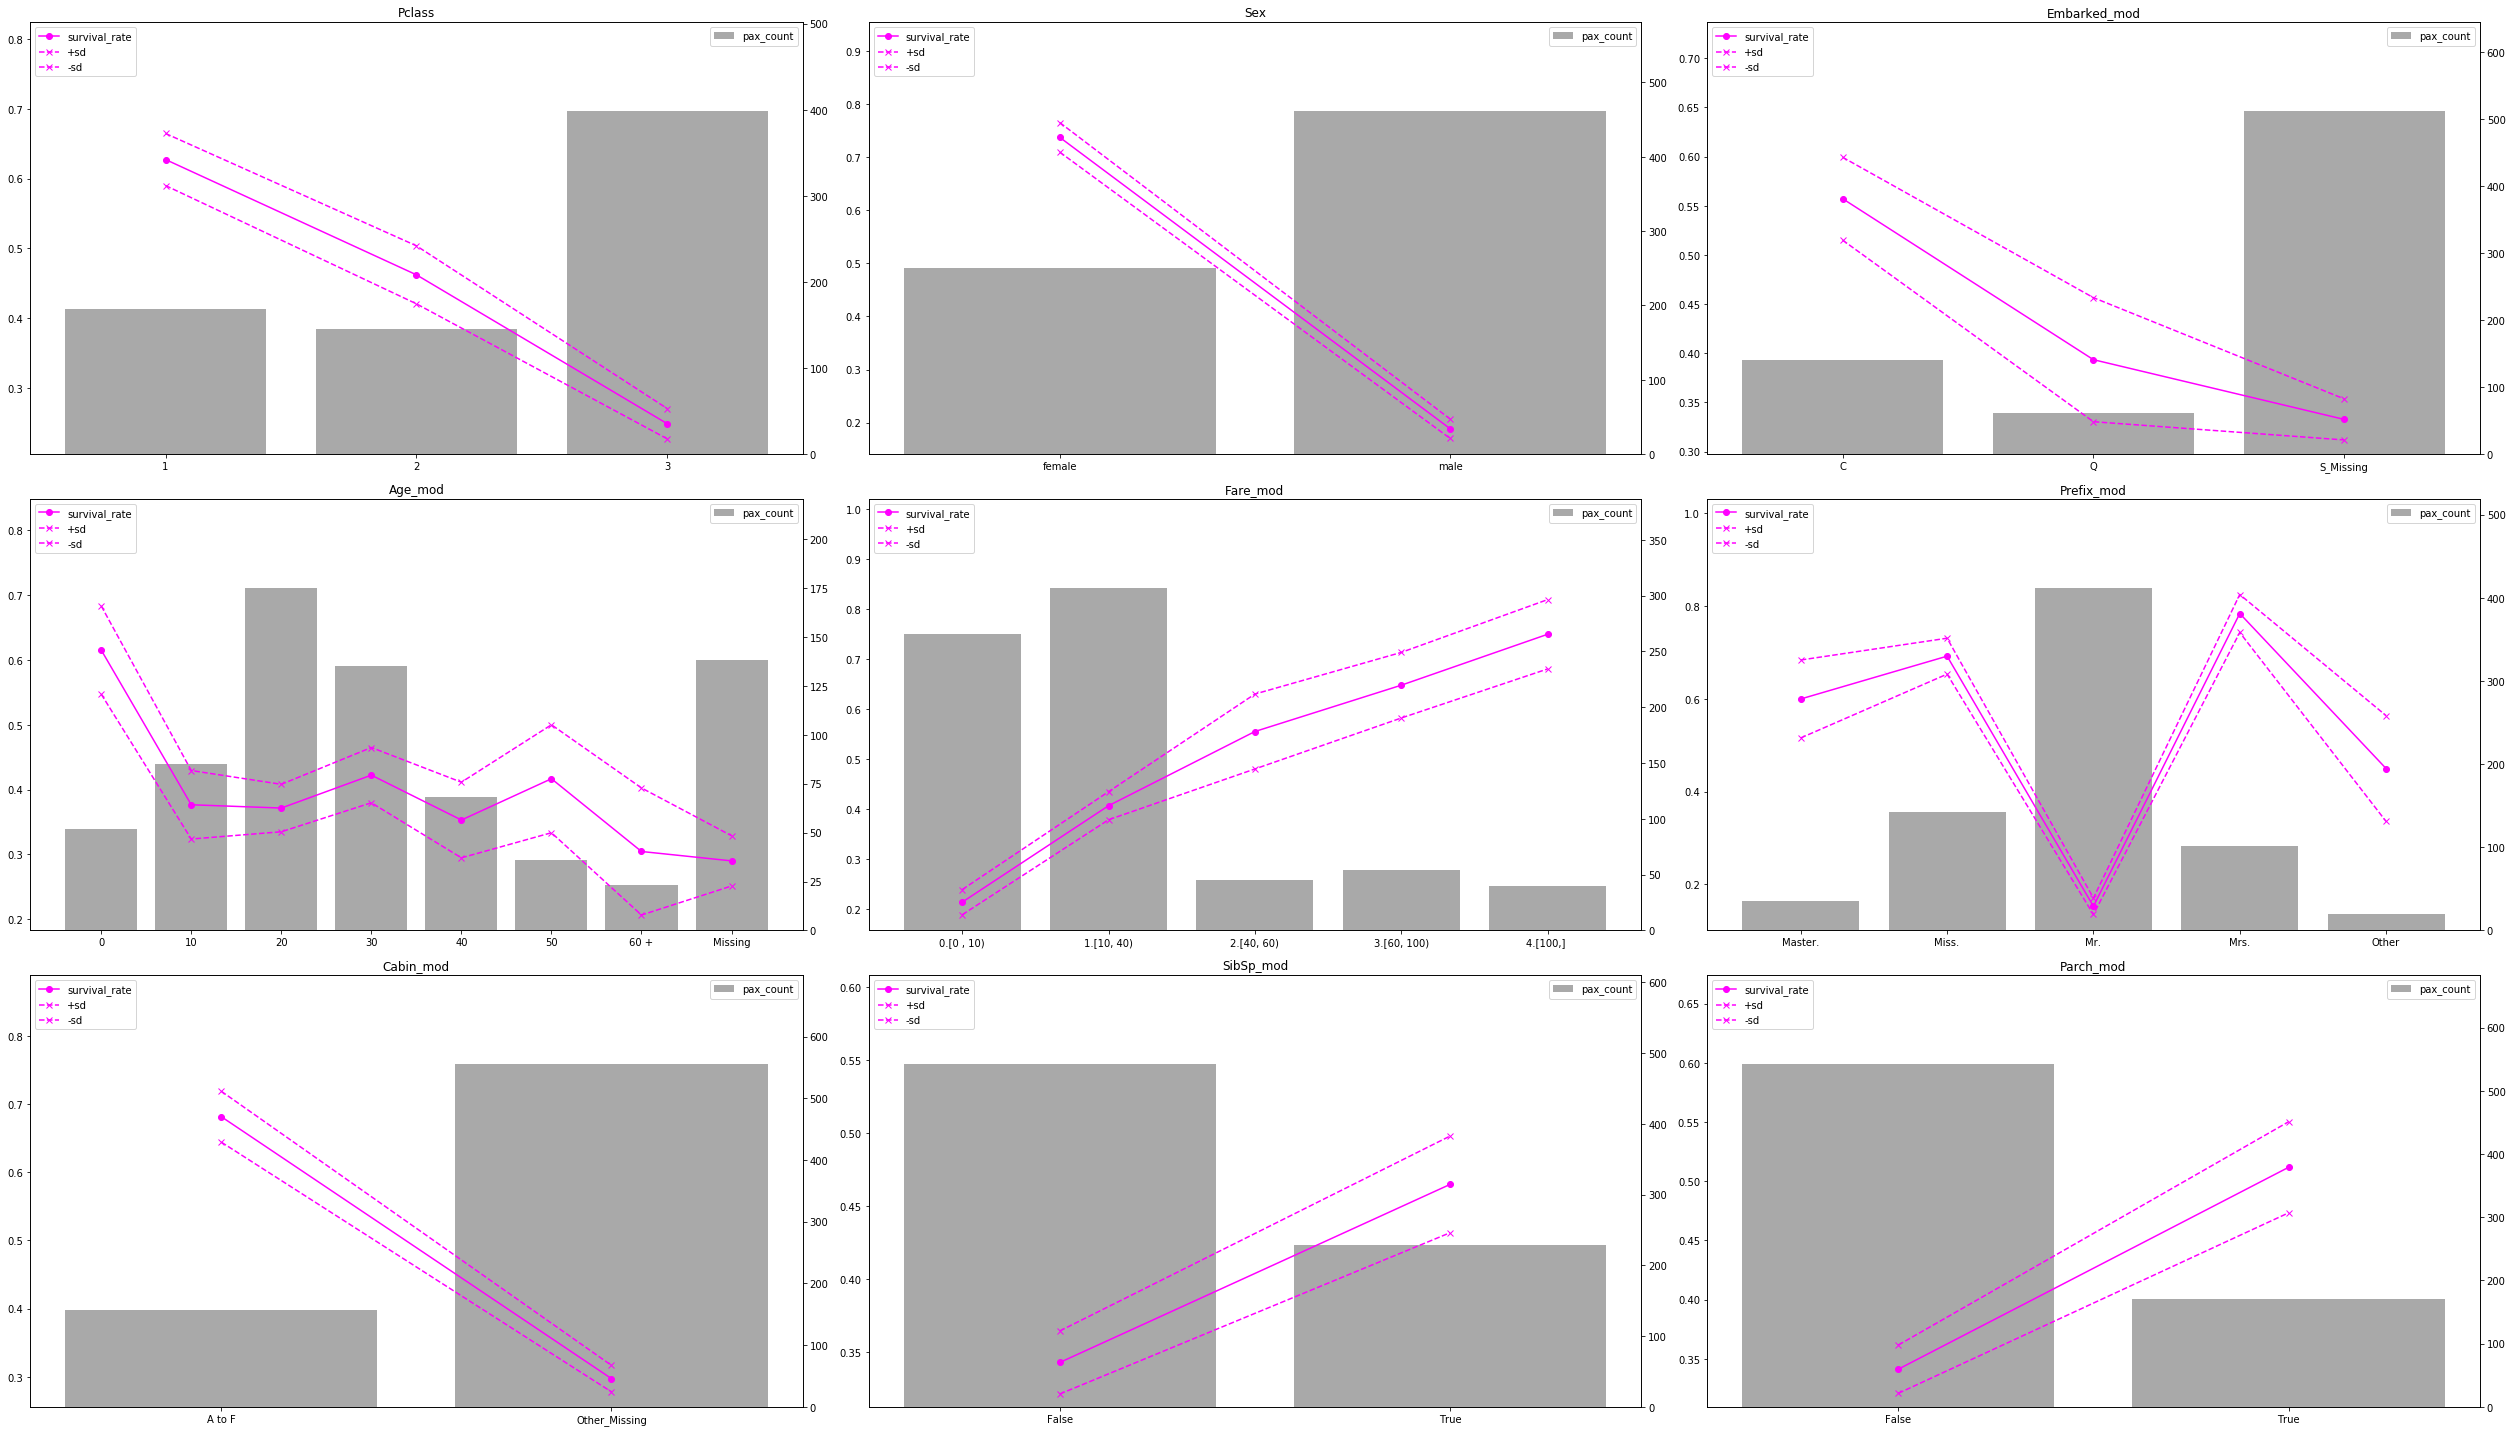

In [77]:
transformed_data = data_transformation_v1().transform(train_data)

fig, axes = plt.subplots(3, 3, figsize=(35, 20))
axes = axes.flatten()

for col, ax in zip(transformed_data.columns, axes):
    
    plt_var_info(var_info(transformed_data, col), ax, {'survival_rate': 'magenta'}, confidence_interval=True, exposure='num_pax')
    ax.set_title(col)
fig.tight_layout()

__Logistic Regression with v1 mod data__
* Set up Machine Learning Pipeline
* Use Gridsearch to tune hyperparameters `C`

best result
> C: 4.5 (this applies less regularization than the previous model which make sense because the variable are in more credible group


In [26]:
# setup  pipe_line
pipe = Pipeline([('data_train', data_transformation_v1()), 
                 ('one_hot', OneHotEncoder()), 
                 ('clf', LogisticRegression())])

# iteration of parameters
params = {'clf__C': [0.001, 0.01, 0.05, 0.1, 1, 5, 10, 50, 100, 1000]}
params = {'clf__C': [2, 3, 4, 5, 6, 7, 8, 9]}
params = {'clf__C': [3.5 + 0.5 * i for i in range(10)]}
params = {'clf__C': [4.5, 4.75, 5, 5.25, 5.5]}

# set up gridsearch and fit model
log_grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
log_grid.fit(train_data, train_label)

result = log_grid.cv_results_  # gridsearch result

# print the best result
string = 'C: {:<5.3f} | accuracy: {:.15f}'
print('best result', ('\n' + string).format(log_grid.best_params_['clf__C'], log_grid.best_score_))
print('-'*100)

# print result by parameter
for param, acc, sd in zip(result['params'], result['mean_test_score'], result['std_test_score']):
    print((string + ' | accuracy SD:{:.5f}').format(param['clf__C'], acc, sd))

best result 
C: 4.500 | accuracy: 0.813223787167449
----------------------------------------------------------------------------------------------------
C: 4.500 | accuracy: 0.813223787167449 | accuracy SD:0.03551
C: 4.750 | accuracy: 0.813223787167449 | accuracy SD:0.03551
C: 5.000 | accuracy: 0.813223787167449 | accuracy SD:0.03551
C: 5.250 | accuracy: 0.813223787167449 | accuracy SD:0.03551
C: 5.500 | accuracy: 0.813223787167449 | accuracy SD:0.03551


__GBM with v1 mod data__
* Set up Machine Learning Pipeline
* Use Gridsearch to tune hyperparameters `learning_rate`, `max_depth`, `min_child_weight`

best result in both accuracy:
>Learning Rate: 0.0400 | max_depth: 3 | min_child_weight: 3

In [27]:
# setup  pipe_line
pipe = Pipeline([('data_train', data_transformation_v1()), 
                 ('one_hot', OneHotEncoder()), 
                 ('clf', XGBClassifier(set_seed=0))])

# iteration of parameters
params = {'clf__learning_rate': [0.01, 0.1, 1],
          'clf__max_depth': [1, 3, 5, 7], 
          'clf__min_child_weight': [1, 2, 3, 5, 10]}

params = {'clf__learning_rate': [0.005, 0.01, 0.015, 0.05, 0.1, 0.15],
          'clf__max_depth': [2, 3, 4], 
          'clf__min_child_weight': [2, 3, 5, 10, 15]}

params = {'clf__learning_rate': [0.15, 0.03, 0.05, 0.07],
          'clf__max_depth': [2, 3, 4], 
          'clf__min_child_weight': [2, 3, 5, 7, 10]}

params = {'clf__learning_rate': [0.04, 0.05, 0.06],
          'clf__max_depth': [2, 3, 4], 
          'clf__min_child_weight': [2, 3, 5, 7, 10]}

params = {'clf__learning_rate': [0.035, 0.04, 0.045],
          'clf__max_depth': [2, 3, 4], 
          'clf__min_child_weight': [2, 3, 5, 7, 10]}

# takeout 2 artificially since grid search select min child_weight 2 to be best when it has same accuracy as 3. I believe 3 will be more generalizable
params = {'clf__learning_rate': [0.035, 0.04, 0.045],
          'clf__max_depth': [2, 3, 4], 
          'clf__min_child_weight': [3, 5, 7, 10]}

# set up gridsearch and fit model
XGB_grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
XGB_grid.fit(train_data, train_label)

result = XGB_grid.cv_results_  # gridsearch result

# print the best result
string = 'Learning Rate: {:<5.4f} | max_depth: {} | min_child_weight: {} | accuracy: {:.10f}'
print('best result:',('\n' + string).format(XGB_grid.best_params_['clf__learning_rate'], 
                                            XGB_grid.best_params_['clf__max_depth'], 
                                            XGB_grid.best_params_['clf__min_child_weight'],
                                            XGB_grid.best_score_))
print('-'*100)

# print avg result by each of the parameters
def print_avg_score(var): 
    param_values = [param['clf__' + var] for param in result['params']]
    for i in sorted(set(param_values)):
        scores = result['mean_test_score'][[p == i for p in param_values]]  # scores for corresponding parameter
        mean_score = np.mean(scores)
        
        scores_sd = result['std_test_score'][[p == i for p in param_values]]  # scores for corresponding parameter
        mean_score_sd = np.mean(scores_sd)
        print('{} {:<5.4f} | avg accuracy: {:.10f} | accuracy SD:{:.10f}'.format(var, i, mean_score, mean_score_sd))
    print('-'*100)
        
print_avg_score('learning_rate')     
print_avg_score('max_depth')     
print_avg_score('min_child_weight')     


# print result by each of the parameters
for param, acc, sd in zip(result['params'], result['mean_test_score'], result['std_test_score']):
    print((string + ' | accuracy SD:{}').format(param['clf__learning_rate'],
                                               param['clf__max_depth'],
                                               param['clf__min_child_weight'],
                                               acc, 
                                               sd))

best result: 
Learning Rate: 0.0400 | max_depth: 2 | min_child_weight: 3 | accuracy: 0.8328638498
----------------------------------------------------------------------------------------------------
learning_rate 0.0350 | avg accuracy: 0.8224553339 | accuracy SD:0.0272825308
learning_rate 0.0400 | avg accuracy: 0.8223363328 | accuracy SD:0.0264770428
learning_rate 0.0450 | avg accuracy: 0.8215147366 | accuracy SD:0.0274764802
----------------------------------------------------------------------------------------------------
max_depth 2.0000 | avg accuracy: 0.8283026865 | accuracy SD:0.0271117242
max_depth 3.0000 | avg accuracy: 0.8184793949 | accuracy SD:0.0278304166
max_depth 4.0000 | avg accuracy: 0.8195243219 | accuracy SD:0.0262939130
----------------------------------------------------------------------------------------------------
min_child_weight 3.0000 | avg accuracy: 0.8230438185 | accuracy SD:0.0301117614
min_child_weight 5.0000 | avg accuracy: 0.8217896887 | accuracy SD:0.

__RF with v1 mod data__
* Set up Machine Learning Pipeline
* Use Gridsearch to tune hyperparameters  `max_depth`, `min_child_weight`

best result in both accuracy and standard deviation of accuracy:
>Learning Rate: 0.1500 | max_depth: 3 | min_child_weight: 10

In [28]:
# setup  pipe_line
pipe = Pipeline([('data_train', data_transformation_v1()), 
                 ('one_hot', OneHotEncoder()), 
                 ('clf', RandomForestClassifier(random_state=0))])

# iteration of parameters
params = {'clf__max_depth': [1, 3, 5, 7], 
          'clf__min_samples_leaf': [1, 2, 3, 5, 10]}

params = {'clf__max_depth': [5, 6, 7], 
          'clf__min_samples_leaf': [3, 5, 7, 9, 11]}

params = {'clf__max_depth': [7, 8, 9], 
          'clf__min_samples_leaf': [3, 5, 7, 9, 11]}

# set up gridsearch and fit model
RF_grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
RF_grid.fit(train_data, train_label)

result = RF_grid.cv_results_  # gridsearch result

# print the best result
string = 'max_depth: {} | min_samples_leaf: {} | accuracy: {:.10f}'
print('best result:',('\n' + string).format(RF_grid.best_params_['clf__max_depth'], 
                                            RF_grid.best_params_['clf__min_samples_leaf'],
                                            RF_grid.best_score_))
print('-'*100)

# print avg result by each of the parameters
def print_avg_score(var): 
    param_values = [param['clf__' + var] for param in result['params']]
    for i in sorted(set(param_values)):
        scores = result['mean_test_score'][[p == i for p in param_values]]  # scores for corresponding parameter
        mean_score = np.mean(scores)
        
        scores_sd = result['std_test_score'][[p == i for p in param_values]]  # scores for corresponding parameter
        mean_score_sd = np.mean(scores_sd)
        print('{} {:<5.4f} | avg accuracy: {:.10f} | accuracy SD:{:.10f}'.format(var, i, mean_score, mean_score_sd))
    print('-'*100)
             
print_avg_score('max_depth')     
print_avg_score('min_samples_leaf')     


# print result by each of the parameters
for param, acc, sd in zip(result['params'], result['mean_test_score'], result['std_test_score']):
    print((string + ' | accuracy SD:{}').format(param['clf__max_depth'],
                                                param['clf__min_samples_leaf'],
                                                acc, 
                                                sd))

best result: 
max_depth: 7 | min_samples_leaf: 3 | accuracy: 0.8201682316
----------------------------------------------------------------------------------------------------
max_depth 7.0000 | avg accuracy: 0.8142957746 | accuracy SD:0.0315946309
max_depth 8.0000 | avg accuracy: 0.8142840376 | accuracy SD:0.0299105995
max_depth 9.0000 | avg accuracy: 0.8131611894 | accuracy SD:0.0299549450
----------------------------------------------------------------------------------------------------
min_samples_leaf 3.0000 | avg accuracy: 0.8187663015 | accuracy SD:0.0351141268
min_samples_leaf 5.0000 | avg accuracy: 0.8154994784 | accuracy SD:0.0317242508
min_samples_leaf 7.0000 | avg accuracy: 0.8140975483 | accuracy SD:0.0287100370
min_samples_leaf 9.0000 | avg accuracy: 0.8108242045 | accuracy SD:0.0270575213
min_samples_leaf 11.0000 | avg accuracy: 0.8103808033 | accuracy SD:0.0298276900
----------------------------------------------------------------------------------------------------
max

__SVC with v1 mod data__
* Set up Machine Learning Pipeline
* Use Gridsearch to tune hyperparameters  `C`,

best result in both accuracy and standard deviation of accuracy:
>Learning Rate: 0.1500 | max_depth: 3 | min_child_weight: 10

In [29]:
# setup  pipe_line
pipe = Pipeline([('data_train', data_transformation_v1()), 
                 ('one_hot', OneHotEncoder()), 
                 ('clf', SVC(random_state=0))])


# iteration of parameters
params = {'clf__C': [0.001, 0.01, 0.05, 0.1, 1, 5, 10, 50, 100, 1000]}
params = {'clf__C': [0.5, 1, 1.5]}
params = {'clf__C': [0.75, 1, 1.25]}
params = {'clf__C': [0.9, 1, 1.1, 1.25, 1.35]}
params = {'clf__C': [0.95, 1, 1.05]}
params = {'clf__C': [0.975, 1, 1.025]}

# set up gridsearch and fit model
SVC_grid = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
SVC_grid.fit(train_data, train_label)

result = SVC_grid.cv_results_  # gridsearch result

# print the best result
string = 'C: {:<5.3f} | accuracy: {:.15f}'
print('best result', ('\n' + string).format(SVC_grid.best_params_['clf__C'], SVC_grid.best_score_))
print('-'*100)

# print result by parameter
for param, acc, sd in zip(result['params'], result['mean_test_score'], result['std_test_score']):
    print((string + ' | accuracy SD:{:.5f}').format(param['clf__C'], acc, sd))

best result 
C: 1.000 | accuracy: 0.825762910798122
----------------------------------------------------------------------------------------------------
C: 0.975 | accuracy: 0.824354460093897 | accuracy SD:0.03010
C: 1.000 | accuracy: 0.825762910798122 | accuracy SD:0.02939
C: 1.025 | accuracy: 0.824374021909233 | accuracy SD:0.02798


# Result on dev data

In [30]:
log = log_grid.best_estimator_
XGB = XGB_grid.best_estimator_
RF = RF_grid.best_estimator_
SV = SVC_grid.best_estimator_

print('logistic regression accuracy train: {:.5%} | dev: {:.5%} | Kaggle Score: {:.3%}'.format(accuracy_score(train_label, log.predict(train_data)), 
                                                                                             accuracy_score(dev_label, log.predict(dev_data)), 0.76076))
print('XGBoost accuracy train: {:.5%} | dev: {:.5%} | Kaggle Score: {:.3%}'.format(accuracy_score(train_label, XGB.predict(train_data)), 
                                                                                 accuracy_score(dev_label, XGB.predict(dev_data)), 0.78947))
print('Random Forest accuracy train: {:.5%} | dev: {:.5%} | Kaggle Score: {:.3%}'.format(accuracy_score(train_label, RF.predict(train_data)), 
                                                                                       accuracy_score(dev_label, RF.predict(dev_data)), 0.78468))
print('Support Vector train: {:.5%} | dev: {:.5%} | Kaggle Score: {:.3%}'.format(accuracy_score(train_label, SV.predict(train_data)), 
                                                                                       accuracy_score(dev_label, SV.predict(dev_data)), 0.78947))

logistic regression accuracy train: 82.44382% | dev: 79.88827% | Kaggle Score: 76.076%
XGBoost accuracy train: 83.98876% | dev: 79.88827% | Kaggle Score: 78.947%
Random Forest accuracy train: 85.25281% | dev: 79.88827% | Kaggle Score: 78.468%
Support Vector train: 85.39326% | dev: 81.00559% | Kaggle Score: 78.947%


# Predict on test dataset

### logistic regression submission

In [31]:
test['Survived'] = log.predict(test)
test[['PassengerId','Survived']].to_csv('data/logistic_reg.csv', index=False)
print('predicted_survival: {:.2%}'.format(test.Survived.mean()))
display(test.head())

predicted_survival: 37.80%


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


### XGBoost submission

In [32]:
test['Survived'] = XGB.predict(test)
test[['PassengerId','Survived']].to_csv('data/XGB.csv', index=False)
print('predicted_survival: {:.2%}'.format(test.Survived.mean()))
display(test.head())

predicted_survival: 29.19%


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


### Random Forest submission

In [33]:
test['Survived'] = RF.predict(test)
test[['PassengerId','Survived']].to_csv('data/RF.csv', index=False)
print('predicted_survival: {:.2%}'.format(test.Survived.mean()))
display(test.head())

predicted_survival: 30.62%


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


### Support Vector submission

In [34]:
test['Survived'] = SV.predict(test)
test[['PassengerId','Survived']].to_csv('data/SV.csv', index=False)
print('predicted_survival: {:.2%}'.format(test.Survived.mean()))
display(test.head())

predicted_survival: 32.78%


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [35]:
print('% of same result from XGB and Logistic regression: {:.3f}'.format((XGB.predict(test) ==  log.predict(test)).mean()))
print('% of same result from XGB and RF regression: {:.3f}'.format((XGB.predict(test) ==  RF.predict(test)).mean()))
print('% of same result from RF and Logistic regression: {:.3f}'.format((log.predict(test) ==  RF.predict(test)).mean()))

% of same result from XGB and Logistic regression: 0.890
% of same result from XGB and RF regression: 0.981
% of same result from RF and Logistic regression: 0.904


In [36]:
ensemble = stats.mode([XGB.predict(test), log.predict(test), RF.predict(test)])[0][0]
test['Survived'] = ensemble
test[['PassengerId','Survived']].to_csv('data/ensemble.csv', index=False)
print('predicted_survival: {:.2%}'.format(test.Survived.mean()))
display(test.head())

predicted_survival: 30.86%


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [80]:
np.std([0,1,0,1,0,1])

0.5